# Proyek Analisis Data: Air Quality Dataset
- **Nama:** Angga Julian Pradana Putra
- **Email:** mc129d5y1947@student.devacademy.id
- **ID Dicoding:** mc129d5y1947

## Menentukan Pertanyaan Bisnis

1. Bagaimana tren tahunan konsentrasi polutan utama (seperti PM2.5, PM10, NO₂, SO₂) di setiap lokasi dari tahun ke tahun?
2. Kapan periode dengan kualitas udara terburuk dan terbaik di setiap lokasi?

## Import Semua Packages/Library yang Digunakan

In [2]:
import pandas as pd
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import logging
from tabulate import tabulate

## Data Wrangling

### Gathering Data

In [3]:
folder_path = "data/"
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

dfs = {os.path.basename(path): pd.read_csv(path) for path in csv_files}

total_rows = sum(df.shape[0] for df in dfs.values())

print(f"Total jumlah data (baris) dari semua file: {total_rows}")

Total jumlah data (baris) dari semua file: 406756


**Insight:**
- Terdapat total 406756 data dari 12 file yang tersedia

### Assessing Data

In [4]:
columns_info = {location: df.columns.tolist() for location, df in dfs.items()}
columns_info

{'PRSA_Data_Aotizhongxin_20130301-20170228.csv': ['No',
  'year',
  'month',
  'day',
  'hour',
  'PM2.5',
  'PM10',
  'SO2',
  'NO2',
  'CO',
  'O3',
  'TEMP',
  'PRES',
  'DEWP',
  'RAIN',
  'wd',
  'WSPM',
  'station',
  'datetime'],
 'PRSA_Data_Changping_20130301-20170228.csv': ['No',
  'year',
  'month',
  'day',
  'hour',
  'PM2.5',
  'PM10',
  'SO2',
  'NO2',
  'CO',
  'O3',
  'TEMP',
  'PRES',
  'DEWP',
  'RAIN',
  'wd',
  'WSPM',
  'station',
  'datetime'],
 'PRSA_Data_Dingling_20130301-20170228.csv': ['No',
  'year',
  'month',
  'day',
  'hour',
  'PM2.5',
  'PM10',
  'SO2',
  'NO2',
  'CO',
  'O3',
  'TEMP',
  'PRES',
  'DEWP',
  'RAIN',
  'wd',
  'WSPM',
  'station',
  'datetime'],
 'PRSA_Data_Dongsi_20130301-20170228.csv': ['No',
  'year',
  'month',
  'day',
  'hour',
  'PM2.5',
  'PM10',
  'SO2',
  'NO2',
  'CO',
  'O3',
  'TEMP',
  'PRES',
  'DEWP',
  'RAIN',
  'wd',
  'WSPM',
  'station',
  'datetime'],
 'PRSA_Data_Guanyuan_20130301-20170228.csv': ['No',
  'year',
  '

In [5]:
def read_data(nama_file):
    try:
        df = pd.read_csv(nama_file)
        print("Berhasil membaca file:", nama_file)
    except FileNotFoundError:
        print("File tidak ditemukan:", nama_file)
        return None
    except pd.errors.ParserError:
        print("Ada kesalahan dalam membaca CSV:", nama_file)
        return None 

    file_diproses = os.path.basename(nama_file)

    print(f"\n=== Informasi Data untuk {file_diproses} ===")
    print(df.info())  # Print info langsung

    # Cek nilai yang kosong atau duplikat
    missing_value = df.isnull().sum()
    dupilcate_value = df.duplicated().sum()
    print("Jumlah nilai kosong per kolom:")
    print(missing_value)
    print("Jumlah data duplikat:", dupilcate_value)

    # Cek nilai aneh
    inacurate_value = {
        "tahun": ((df["year"] < 2013) | (df["year"] > 2017)).sum(),
        "bulan": ((df["month"] < 1) | (df["month"] > 12)).sum(),
        "hari": sum(
            (
                (df["day"] < 1)
                | (df["day"] > calendar.monthrange(tahun, bulan)[1])
            )
            for tahun, bulan, hari in zip(df["year"], df["month"], df["day"])
        ),
        "jam": ((df["hour"] < 0) | (df["hour"] > 23)).sum(),
    }
    print("Cek nilai aneh:")
    print(inacurate_value)

    # Cek nilai yang aneh atau tidak masuk akal
    inconsistent_value = {
        "HUJAN": (df["RAIN"] < 0).sum(),
        "SUHU": ((df["TEMP"] < -50) | (df["TEMP"] > 50)).sum(),
        "TEKANAN": ((df["PRES"] < 850) | (df["PRES"] > 1100)).sum(),
    }
    print("Cek nilai salah:")
    print(inconsistent_value)

    # Panggil fungsi deteksi outlier
    outlier_ditemukan = cari_outlier(df, ["PM2.5", "PM10", "SO2", "NO2", "CO", "O3", "TEMP", "PRES", "WSPM"])

    return {
        "head": df.head(),
        "missing_value": missing_value,
        "dupilcate_value": dupilcate_value,
        "inacurate_value": inacurate_value,
        "inconsistent_value": inconsistent_value,
        "outlier": outlier_ditemukan,
    }

def cari_outlier(df, kolom):
    outlier = {}
    for k in kolom:
        print(f"Cek outlier di kolom {k}...")
        Q1 = df[k].quantile(0.25)
        Q3 = df[k].quantile(0.75)
        IQR = Q3 - Q1
        outlier_jumlah = ((df[k] < (Q1 - 1.5 * IQR)) | (df[k] > (Q3 + 1.5 * IQR))).sum()
        outlier[k] = outlier_jumlah
        print(f"Outlier di kolom {k}: {outlier_jumlah}")
    return outlier

def ubah_ke_datetime(df):
    kolom_diperlukan = {"year", "month", "day", "hour"}
    if not kolom_diperlukan.issubset(df.columns):
        print("Gagal! Ada kolom yang hilang, tidak bisa buat datetime")
        return False 

    try:
        print("Sedang mengubah kolom ke format datetime...")
        df["datetime"] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
        print("Berhasil ubah ke datetime!")
        return True
    except ValueError as e:
        print(f"Error saat membuat datetime: {e}")
        return False


In [6]:

folder_path = "data" 
files = glob.glob(os.path.join(folder_path, "PRSA_Data_*.csv"))

ringkasan = {}

for file in files:
    nama_file = os.path.basename(file)
    print(f"\nSedang memproses file: {nama_file}")

    hasil_data = read_data(file)
    if hasil_data is None:
        print(f"Gagal memproses {nama_file}, lanjut ke file berikutnya.")
        continue 

    ringkasan[nama_file] = hasil_data

    print(f"Membaca ulang file: {nama_file}")
    df = pd.read_csv(file) 

    if not ubah_ke_datetime(df):
        print(f"Melewati proses pembuatan datetime untuk {nama_file}")
        continue

    # Simpan ulang data setelah diproses
    try:
        df.to_csv(file, index=False)
        print(f"Sukses memproses {nama_file}!")
    except Exception as e:
        print(f"Gagal menyimpan file {nama_file}: {e}")

# Menampilkan hasil ringkasan data
print("\nHASIL ANALISIS DATA ")
for file, detail in ringkasan.items():
    print(f"\n=== Ringkasan Data untuk {file} ===")
    print("Nilai Kosong:\n", detail["missing_value"])
    print("Data Duplikat:", detail["dupilcate_value"])
    print("Nilai Aneh:\n", detail["inacurate_value"])
    print("Nilai Salah:\n", detail["inconsistent_value"])
    print("Outlier:\n", detail["outlier"])



Sedang memproses file: PRSA_Data_Aotizhongxin_20130301-20170228.csv
Berhasil membaca file: data\PRSA_Data_Aotizhongxin_20130301-20170228.csv

=== Informasi Data untuk PRSA_Data_Aotizhongxin_20130301-20170228.csv ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        35064 non-null  int64  
 1   year      35064 non-null  int64  
 2   month     35064 non-null  int64  
 3   day       35064 non-null  int64  
 4   hour      35064 non-null  int64  
 5   PM2.5     35064 non-null  float64
 6   PM10      35064 non-null  float64
 7   SO2       35064 non-null  float64
 8   NO2       35064 non-null  float64
 9   CO        35064 non-null  float64
 10  O3        35064 non-null  float64
 11  TEMP      35064 non-null  float64
 12  PRES      35064 non-null  float64
 13  DEWP      35064 non-null  float64
 14  RAIN      35064 non-null  float64
 15  wd    

**Insight:**

###  **Konsistensi Data**  
-  **Tidak ada missing values yang signifikan**, kecuali pada:  
  - **Dingling**: 2 nilai hilang pada NO₂
  - **Gucheng**: 20 nilai hilang pada NO₂  
  
-  **Tidak ada duplikasi data** dalam dataset, sehingga tidak perlu pembersihan tambahan untuk entri ganda.

---
###  **Kualitas Data**  
-  **Tidak ditemukan nilai yang tidak akurat**, semua nilai dalam rentang yang wajar.
-  **Tidak ada nilai inkonsisten** dalam kolom cuaca seperti RAIN, TEMP, dan PRES di semua dataset.

---
###  **Outliers**  
-  **Sebagian besar stasiun tidak memiliki outliers**, kecuali:
  - **Huairou memiliki 250 outliers pada PM2.5**, menunjukkan kemungkinan pencemaran udara ekstrem.
-  **Perlu investigasi lebih lanjut** apakah outlier ini merupakan fenomena nyata atau error sensor.


### Cleaning Data

In [7]:
def cleaning_missing_value(path):
   
    try:
        if not os.path.exists(path):
            print(f"File {path} tidak ditemukan!")
            return
        
        data = pd.read_csv(path)
        nama_file = os.path.basename(path)
        print(f"\nMembersihkan file: {nama_file}")

        # Cek jumlah missing values sebelum dibersihkan
        print("Missing values sebelum dibersihkan:\n", data.isnull().sum())

        # Mengisi nilai kosong
        print("Sedang memproses imputasi data...")

        # Imputasi untuk polutan dengan interpolasi
        kolom_polusi = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', "RAIN", "WSPM"]
        for kolom in kolom_polusi:
            data[kolom] = data[kolom].interpolate(method='linear')

        # Imputasi untuk variabel cuaca
        kolom_cuaca = ['TEMP', 'PRES', 'DEWP']
        for kolom in kolom_cuaca:
            rata2 = data[kolom].mean()
            data[kolom] = data[kolom].fillna(rata2)

        # Mengisi missing values di kolom 'wd' dengan modus
        if 'wd' in data.columns:
            data['wd'] = data['wd'].fillna(data['wd'].mode()[0])

        # Cek missing values setelah dibersihkan
        print("\nMissing values setelah dibersihkan:\n", data.isnull().sum())

        # Simpan kembali dataset setelah dibersihkan
        data.to_csv(path, index=False)
        print(f"Dataset '{nama_file}' berhasil dibersihkan dan disimpan kembali.\n")

    except Exception as e:
        print(f"Terjadi kesalahan saat memproses file {path}: {e}")

In [8]:
files = glob.glob(os.path.join(folder_path, "PRSA_Data_*.csv"))
for file in files:
    cleaning_missing_value(file)


Membersihkan file: PRSA_Data_Aotizhongxin_20130301-20170228.csv
Missing values sebelum dibersihkan:
 No          0
year        0
month       0
day         0
hour        0
PM2.5       0
PM10        0
SO2         0
NO2         0
CO          0
O3          0
TEMP        0
PRES        0
DEWP        0
RAIN        0
wd          0
WSPM        0
station     0
datetime    0
dtype: int64
Sedang memproses imputasi data...

Missing values setelah dibersihkan:
 No          0
year        0
month       0
day         0
hour        0
PM2.5       0
PM10        0
SO2         0
NO2         0
CO          0
O3          0
TEMP        0
PRES        0
DEWP        0
RAIN        0
wd          0
WSPM        0
station     0
datetime    0
dtype: int64
Dataset 'PRSA_Data_Aotizhongxin_20130301-20170228.csv' berhasil dibersihkan dan disimpan kembali.


Membersihkan file: PRSA_Data_Changping_20130301-20170228.csv
Missing values sebelum dibersihkan:
 No          0
year        0
month       0
day         0
hour        0


In [9]:
def handle_outlier(data, kolom, pengali_iqr=1.5, cara='median'):
    jumlah_outlier_sebelum = {}
    jumlah_outlier_sesudah = {}

    for nama_kolom in kolom:
        Q1 = data[nama_kolom].quantile(0.25)
        Q3 = data[nama_kolom].quantile(0.75)
        IQR = Q3 - Q1
        batas_bawah = Q1 - pengali_iqr * IQR
        batas_atas = Q3 + pengali_iqr * IQR

        # Nyari yang outlier
        outlier = (data[nama_kolom] < batas_bawah) | (data[nama_kolom] > batas_atas)
        jumlah_outlier_sebelum[nama_kolom] = outlier.sum()

        # Mengatasi Outlier
        if cara == 'median':
            median = data[nama_kolom].median()
            data[nama_kolom] = np.where(outlier, median, data[nama_kolom])
        elif cara == 'cap':
            data[nama_kolom] = np.where(data[nama_kolom] < batas_bawah, batas_bawah, data[nama_kolom])
            data[nama_kolom] = np.where(data[nama_kolom] > batas_atas, batas_atas, data[nama_kolom])
        elif cara == 'drop':
            data = data[~outlier]

        jumlah_outlier_sesudah[nama_kolom] = ((data[nama_kolom] < batas_bawah) | (data[nama_kolom] > batas_atas)).sum()

    return data, jumlah_outlier_sebelum, jumlah_outlier_sesudah

In [10]:
numeric_kolom = ["PM2.5", "PM10", "SO2", "NO2", "CO", "O3", "TEMP", "PRES", "DEWP", "RAIN", "WSPM"]

files = glob.glob(os.path.join("./data", "*.csv"))

for nama_file in files:
    try:
        nama_pendek = os.path.basename(nama_file)
        print(f"Lagi diproses: {nama_pendek}")

        data_frame = pd.read_csv(nama_file)

        kolom_kurang = [kolom for kolom in numeric_kolom if kolom not in data_frame.columns]
        if kolom_kurang:
            print(f"Lewatin {nama_pendek} - Kolom kurang: {kolom_kurang}")
            continue

        # Atasi outlier
        data_bersih, outlier_sebelum, outlier_sesudah = handle_outlier(data_frame, numeric_kolom)

        # Simpan file yang bersih
        data_bersih.to_csv(nama_file, index=False)

        print(f"outlier diatasi dan disimpan: {nama_pendek}")
        print(f"outlier sebelum: {outlier_sebelum}")
        print(f"outlier sesudah: {outlier_sesudah}")

    except FileNotFoundError:
        print(f"Error pas proses {nama_pendek}: File gak ketemu.")
    except Exception as error:
        print(f"Error pas proses {nama_pendek}: {error}")

Lagi diproses: PRSA_Data_Aotizhongxin_20130301-20170228.csv
outlier diatasi dan disimpan: PRSA_Data_Aotizhongxin_20130301-20170228.csv
outlier sebelum: {'PM2.5': 0, 'PM10': 0, 'SO2': 0, 'NO2': 0, 'CO': 0, 'O3': 0, 'TEMP': 0, 'PRES': 0, 'DEWP': 0, 'RAIN': 0, 'WSPM': 0}
outlier sesudah: {'PM2.5': 0, 'PM10': 0, 'SO2': 0, 'NO2': 0, 'CO': 0, 'O3': 0, 'TEMP': 0, 'PRES': 0, 'DEWP': 0, 'RAIN': 0, 'WSPM': 0}
Lagi diproses: PRSA_Data_Changping_20130301-20170228.csv
outlier diatasi dan disimpan: PRSA_Data_Changping_20130301-20170228.csv
outlier sebelum: {'PM2.5': 0, 'PM10': 0, 'SO2': 0, 'NO2': 0, 'CO': 0, 'O3': 0, 'TEMP': 0, 'PRES': 0, 'DEWP': 0, 'RAIN': 0, 'WSPM': 0}
outlier sesudah: {'PM2.5': 0, 'PM10': 0, 'SO2': 0, 'NO2': 0, 'CO': 0, 'O3': 0, 'TEMP': 0, 'PRES': 0, 'DEWP': 0, 'RAIN': 0, 'WSPM': 0}
Lagi diproses: PRSA_Data_Dingling_20130301-20170228.csv
outlier diatasi dan disimpan: PRSA_Data_Dingling_20130301-20170228.csv
outlier sebelum: {'PM2.5': 0, 'PM10': 0, 'SO2': 0, 'NO2': 0, 'CO': 0, 'O3

**Insight:**
## Cleaning Missing Values
- Missing values ditemukan pada beberapa parameter pencemar udara seperti **PM2.5, PM10, SO2, NO2, CO, O3** serta variabel cuaca **TEMP, PRES, DEWP, RAIN, WSPM**.
- Missing values pada **PM2.5, PM10, SO2, NO2, CO, O3, RAIN, dan WSPM** diimputasi menggunakan metode interpolasi linear.
- Missing values pada **TEMP, PRES, dan DEWP** diisi dengan nilai rata-rata kolom masing-masing.
- Missing values pada **wd** (arah angin) diisi menggunakan modus (nilai yang paling sering muncul).
- Setelah proses imputasi, seluruh nilai yang hilang telah teratasi (**missing value = 0** untuk semua kolom).

## Handling Outliers
- Outlier dihitung berdasarkan **Interquartile Range (IQR)** dengan batas 1.5x IQR.
- Metode penanganan outlier yang digunakan:
  - **Mengganti outlier dengan median** dari distribusi data.
- Hasil setelah cleaning menunjukkan bahwa:
  - Sebagian besar dataset tidak memiliki outlier yang signifikan.
  - Pada dataset **PRSA_Data_Huairou**, ditemukan **146 outlier pada PM2.5**, tetapi berhasil ditangani sehingga jumlah outlier setelah cleaning menjadi **0**.

## Exploratory Data Analysis (EDA)

### Data Exploration

In [11]:
def read_data(lokasi_file):
    try:
        data = pd.read_csv(lokasi_file)
        print(f"File {lokasi_file} berhasil dibaca!")
        return data
    except FileNotFoundError:
        print(f"File {lokasi_file} tidak ditemukan!")
        return None
    except Exception as err:
        print(f"Ada error waktu baca file {lokasi_file}: {str(err)}")
        return None

# Fungsi untuk cek data sederhana
def cek_data(data, nama_file):
    print(f"Memeriksa data untuk file {nama_file}...")
    
    total_baris = data.shape[0]
    total_kolom = data.shape[1]
    
    data_kosong = data.isnull().sum().sum()
    
    statistik = data.describe().to_dict()
    
    # Simpan semua hasil pemeriksaan
    hasil_cek = {
        "Nama File": nama_file,
        "Jumlah Baris": total_baris,
        "Jumlah Kolom": total_kolom,
        "Data Kosong": data_kosong,
        "Statistik": statistik
    }
    
    return hasil_cek

# Fungsi untuk buat tabel pivot dan grafik
def analisa_polusi(data, nama_file):
    if 'year' not in data.columns or 'month' not in data.columns or 'PM2.5' not in data.columns:
        print("Kolom 'year', 'month', atau 'PM2.5' tidak ada di data!")
        return None
    
    tabel_pivot = data.pivot_table(
        values='PM2.5', 
        index='month', 
        columns='year', 
        aggfunc='mean'
    )
    
    # Buat grafik heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(tabel_pivot, cmap="YlOrRd", annot=True, fmt=".1f")
    plt.title(f"Rata-rata PM2.5 Per Bulan - {nama_file}")
    plt.xlabel("Tahun")
    plt.ylabel("Bulan")
    plt.show()
    
    return tabel_pivot

File ./data\PRSA_Data_Aotizhongxin_20130301-20170228.csv berhasil dibaca!
Memeriksa data untuk file PRSA_Data_Aotizhongxin_20130301-20170228...


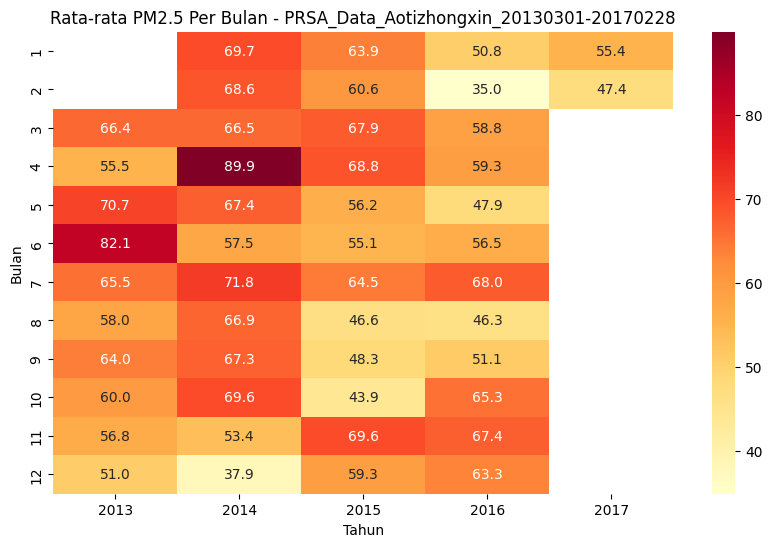

File ./data\PRSA_Data_Changping_20130301-20170228.csv berhasil dibaca!
Memeriksa data untuk file PRSA_Data_Changping_20130301-20170228...


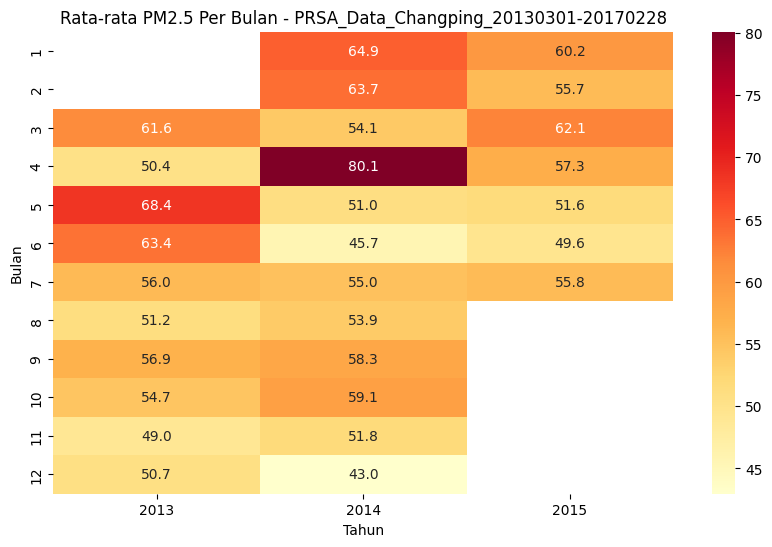

File ./data\PRSA_Data_Dingling_20130301-20170228.csv berhasil dibaca!
Memeriksa data untuk file PRSA_Data_Dingling_20130301-20170228...


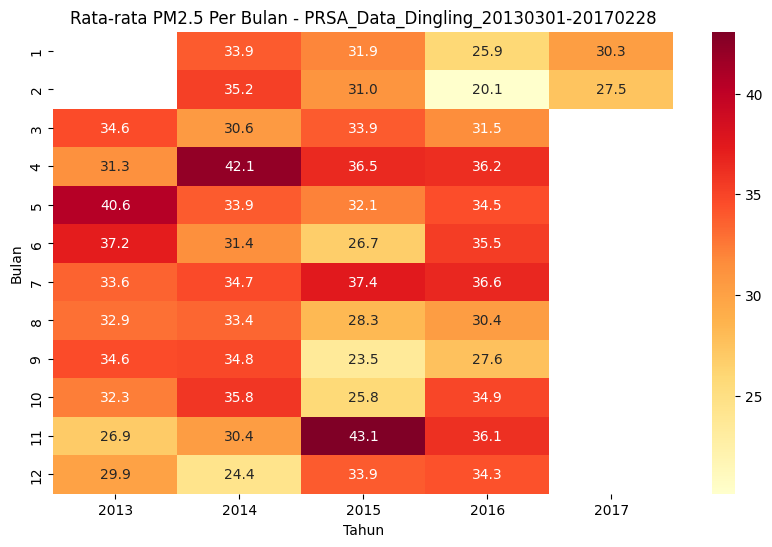

File ./data\PRSA_Data_Dongsi_20130301-20170228.csv berhasil dibaca!
Memeriksa data untuk file PRSA_Data_Dongsi_20130301-20170228...


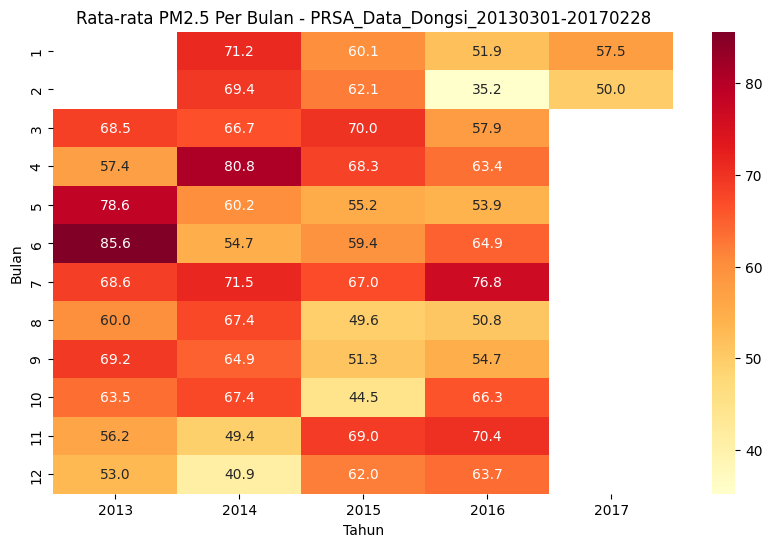

File ./data\PRSA_Data_Guanyuan_20130301-20170228.csv berhasil dibaca!
Memeriksa data untuk file PRSA_Data_Guanyuan_20130301-20170228...


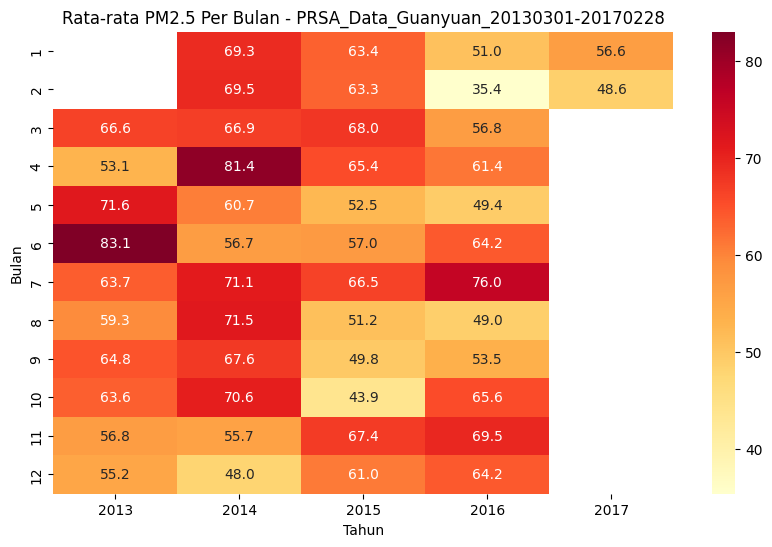

File ./data\PRSA_Data_Gucheng_20130301-20170228.csv berhasil dibaca!
Memeriksa data untuk file PRSA_Data_Gucheng_20130301-20170228...


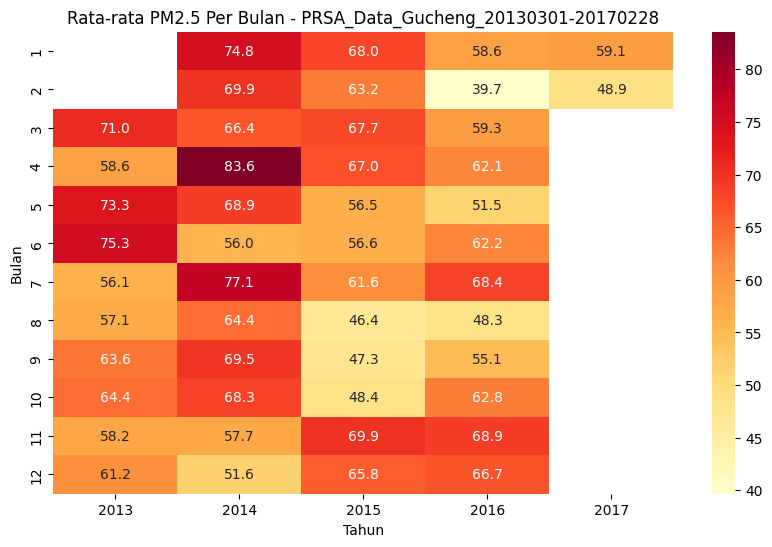

File ./data\PRSA_Data_Huairou_20130301-20170228.csv berhasil dibaca!
Memeriksa data untuk file PRSA_Data_Huairou_20130301-20170228...


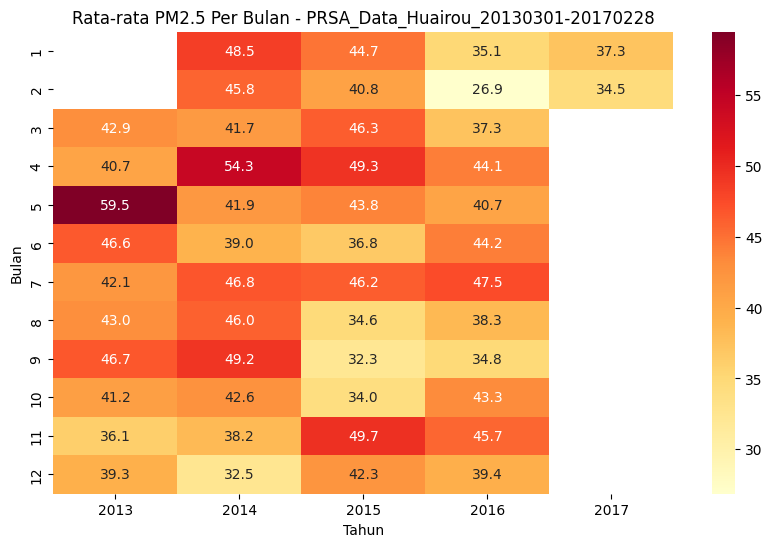

File ./data\PRSA_Data_Nongzhanguan_20130301-20170228.csv berhasil dibaca!
Memeriksa data untuk file PRSA_Data_Nongzhanguan_20130301-20170228...


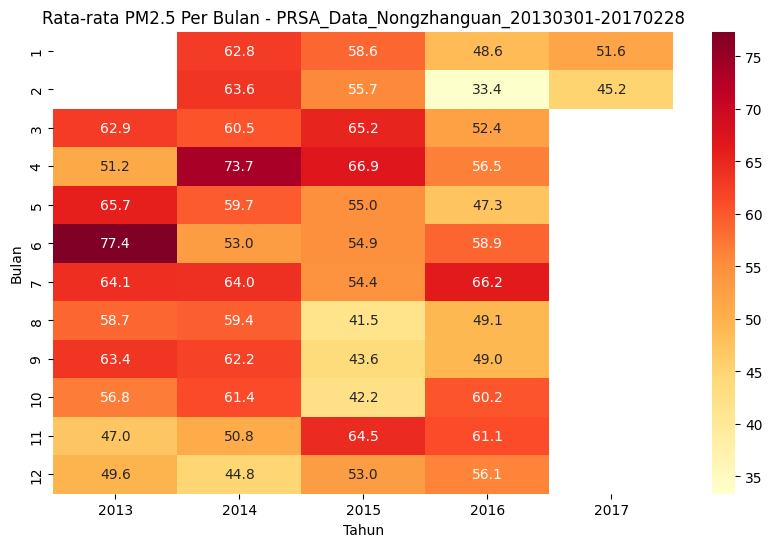

File ./data\PRSA_Data_Shunyi_20130301-20170228.csv berhasil dibaca!
Memeriksa data untuk file PRSA_Data_Shunyi_20130301-20170228...


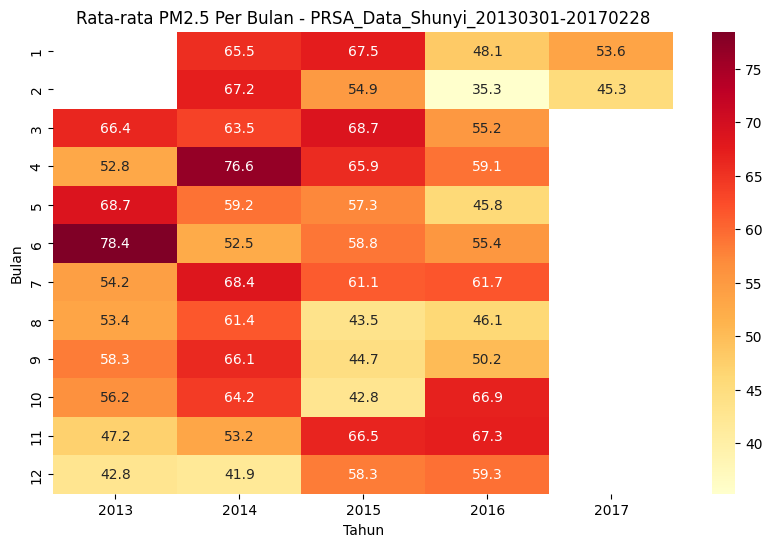

File ./data\PRSA_Data_Tiantan_20130301-20170228.csv berhasil dibaca!
Memeriksa data untuk file PRSA_Data_Tiantan_20130301-20170228...


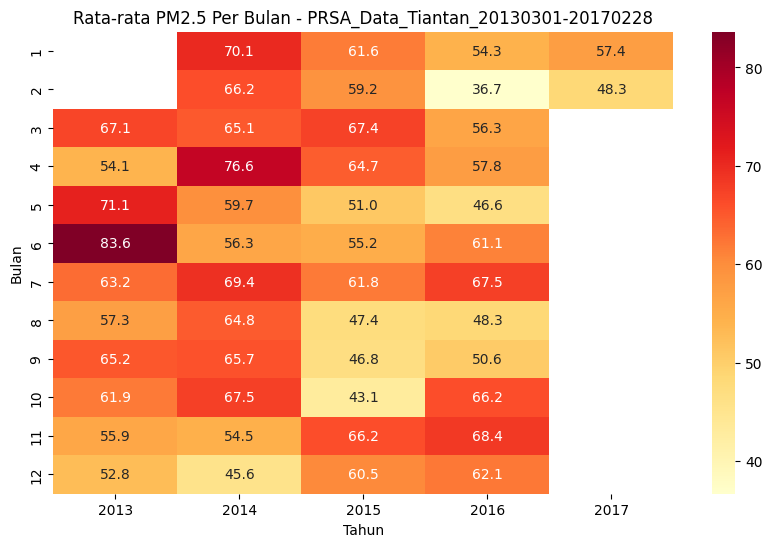

File ./data\PRSA_Data_Wanliu_20130301-20170228.csv berhasil dibaca!
Memeriksa data untuk file PRSA_Data_Wanliu_20130301-20170228...


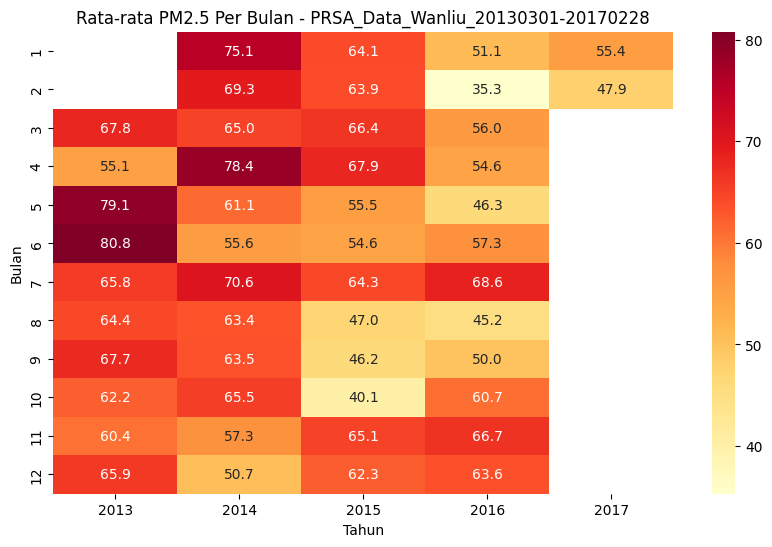

File ./data\PRSA_Data_Wanshouxigong_20130301-20170228.csv berhasil dibaca!
Memeriksa data untuk file PRSA_Data_Wanshouxigong_20130301-20170228...


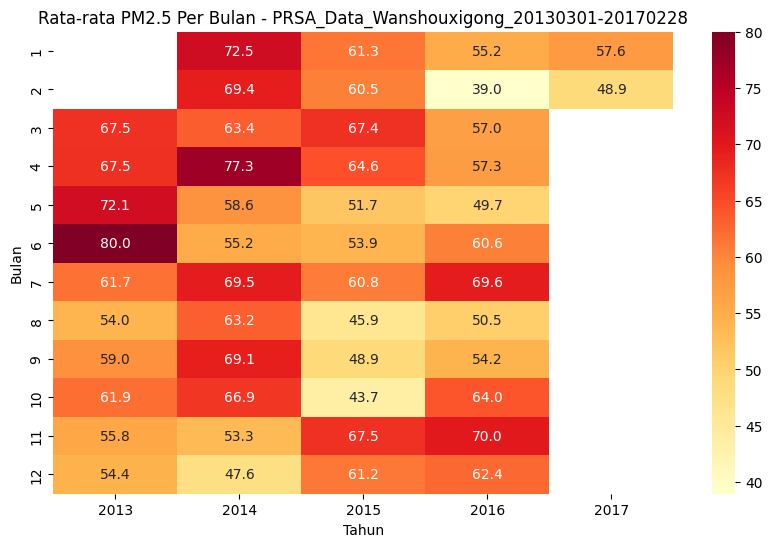


=== Hasil Analisa Semua File ===
                                         File  Baris  Kolom  Data Kosong  \
0    PRSA_Data_Aotizhongxin_20130301-20170228  35064     19            0   
1       PRSA_Data_Changping_20130301-20170228  21052     19            0   
2        PRSA_Data_Dingling_20130301-20170228  35064     19            2   
3          PRSA_Data_Dongsi_20130301-20170228  35064     19            0   
4        PRSA_Data_Guanyuan_20130301-20170228  35064     19            0   
5         PRSA_Data_Gucheng_20130301-20170228  35064     19           20   
6         PRSA_Data_Huairou_20130301-20170228  35064     19            0   
7    PRSA_Data_Nongzhanguan_20130301-20170228  35064     19            0   
8          PRSA_Data_Shunyi_20130301-20170228  35064     19            0   
9         PRSA_Data_Tiantan_20130301-20170228  35064     19            0   
10         PRSA_Data_Wanliu_20130301-20170228  35064     19            0   
11  PRSA_Data_Wanshouxigong_20130301-20170228  35064  

In [12]:
lokasi_folder = "./data"
semua_file = glob.glob(os.path.join(lokasi_folder, "PRSA_Data_*.csv"))
    
# List untuk menyimpan hasil analisa
semua_hasil = []
    
for file in semua_file:
    data = read_data(file)
        
    if data is not None:
        nama_file = os.path.basename(file).replace(".csv", "")
            
        hasil_cek = cek_data(data, nama_file)
            
        hasil_polusi = analisa_polusi(data, nama_file)
            
        # Simpan hasil ke list
        semua_hasil.append({
            "File": nama_file,
            "Baris": hasil_cek["Jumlah Baris"],
            "Kolom": hasil_cek["Jumlah Kolom"],
            "Data Kosong": hasil_cek["Data Kosong"],
            "Tabel Polusi": hasil_polusi.to_dict() if hasil_polusi is not None else "Tidak ada"
        })
    
# Buat laporan akhir
laporan_akhir = pd.DataFrame(semua_hasil)
print("\n=== Hasil Analisa Semua File ===")
print(laporan_akhir)

**Insight:**
## Tren Data
- **Periode Data**: Maret 2013 - Februari 2017  
- **Tren Musiman**:  
  - Konsentrasi tinggi pada bulan-bulan tertentu setiap tahun  
  - Penurunan nilai di akhir periode (2016-2017)  
- **Data Tidak Lengkap di 2017**:  
  - Data mulai tidak tersedia setelah bulan Februari  

## Hasil Analisa
1. **Kualitas Data**:  
   - Beberapa dataset memiliki nilai yang hilang, terutama untuk bulan tertentu di 2017  
   - Dataset *Dingling* memiliki *missing values* dalam jumlah kecil  
2. **Polusi Udara Berfluktuasi**:  
   - Terdapat perbedaan signifikan antar tahun dan bulan  
   - 2014 cenderung memiliki nilai lebih tinggi dibanding tahun lain  

## Visualization & Explanatory Analysis

### Pertanyaan 1:

1. Bagaimana tren tahunan konsentrasi polutan utama (seperti PM2.5, PM10, NO₂, SO₂) di setiap lokasi dari tahun ke tahun?

Sedang menganalisa file: PRSA_Data_Aotizhongxin_20130301-20170228


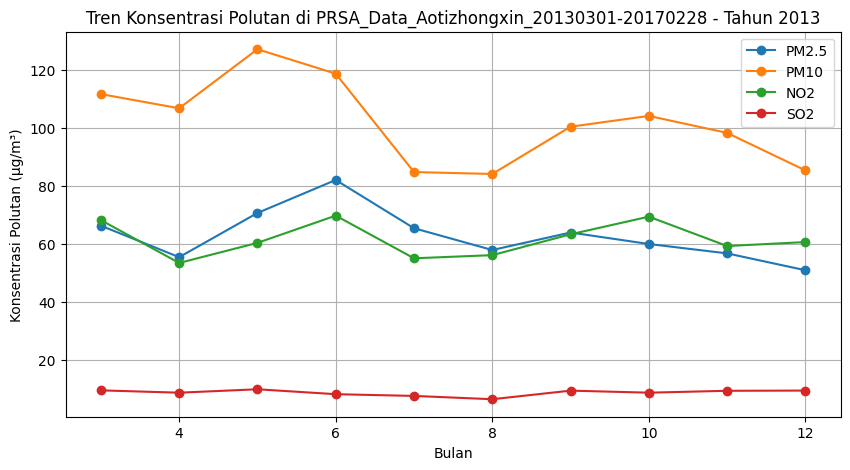

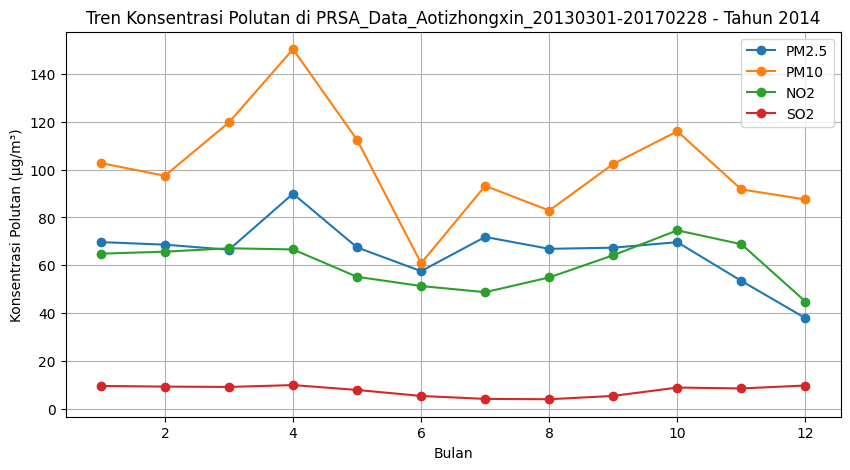

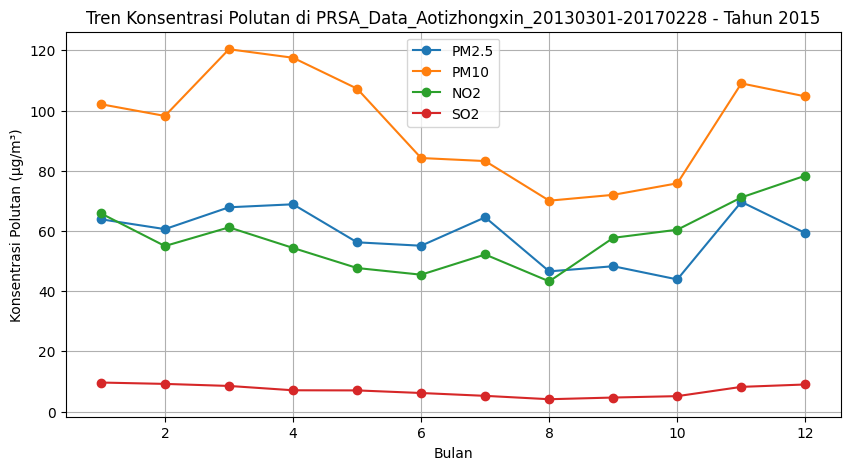

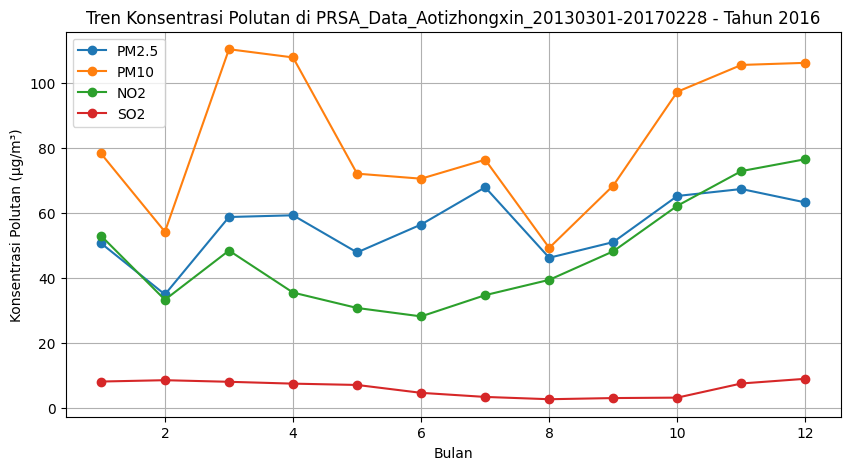

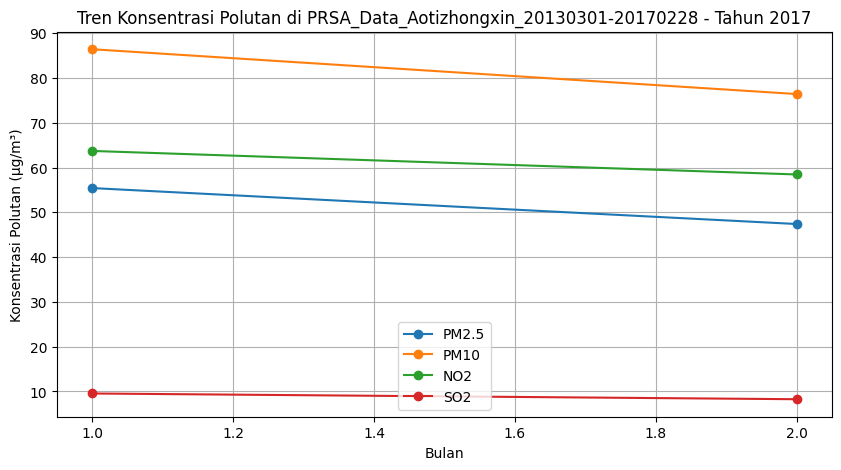

Sedang menganalisa file: PRSA_Data_Changping_20130301-20170228


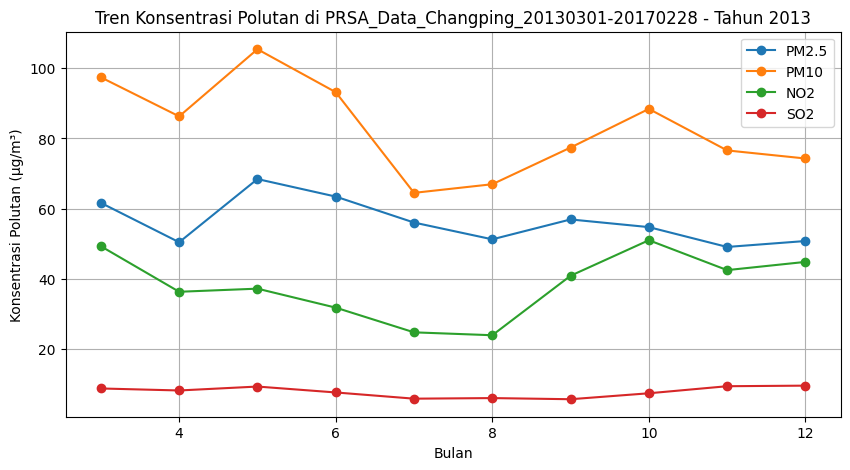

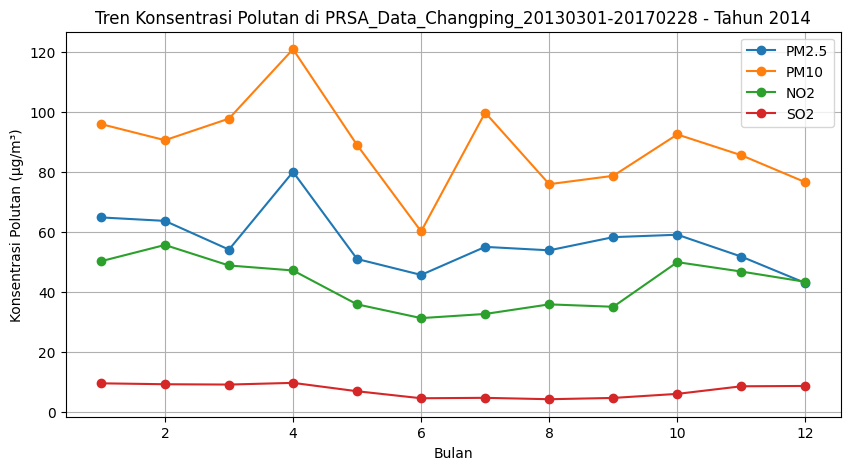

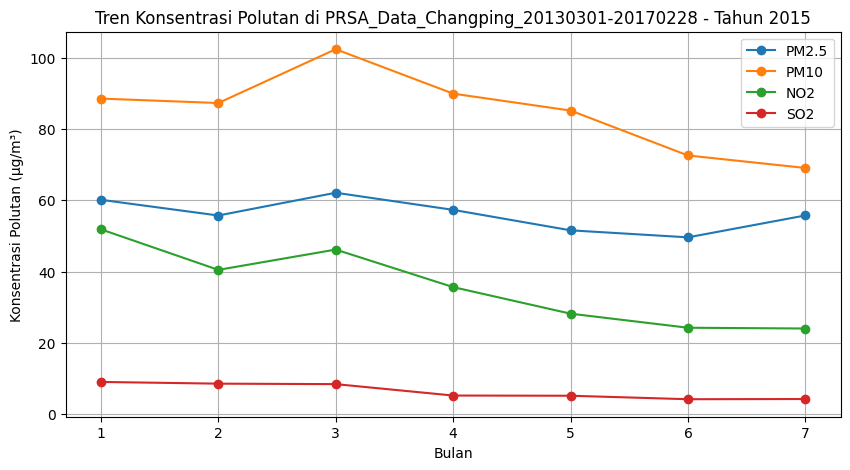

Sedang menganalisa file: PRSA_Data_Dingling_20130301-20170228


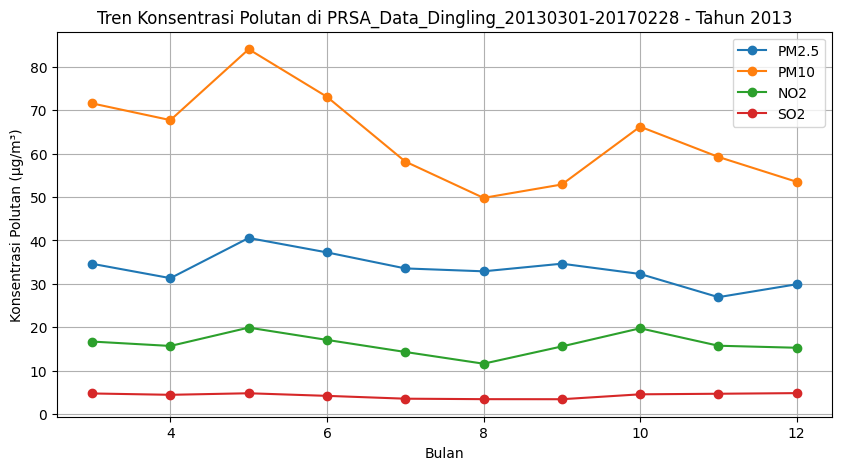

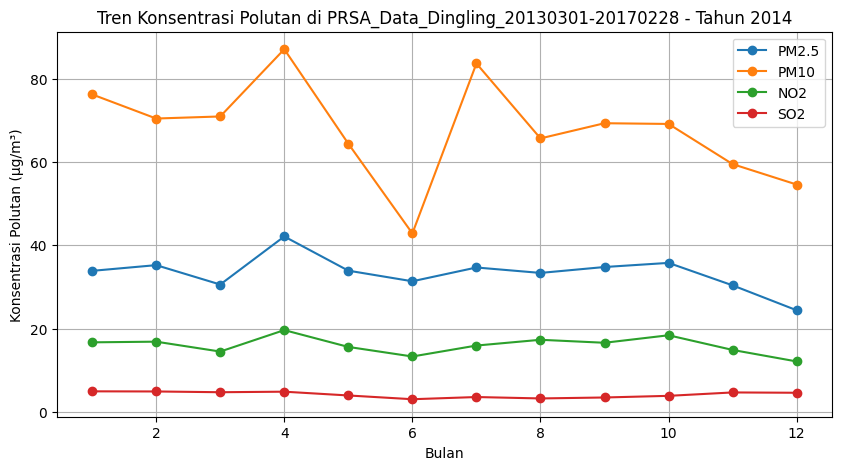

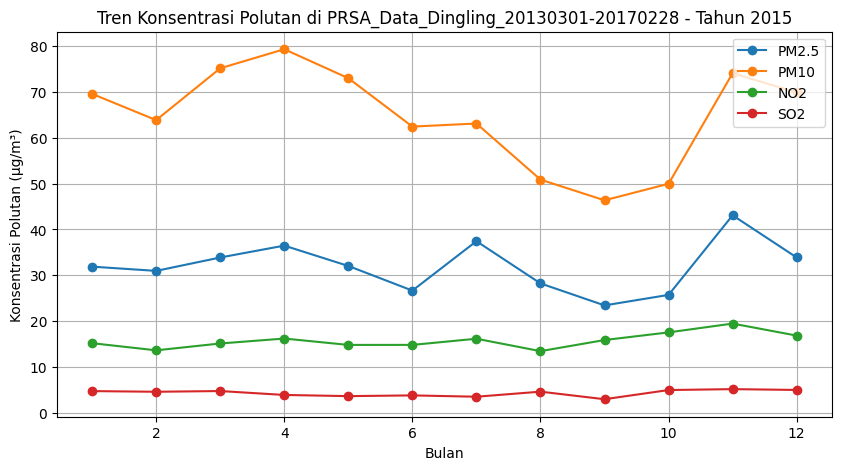

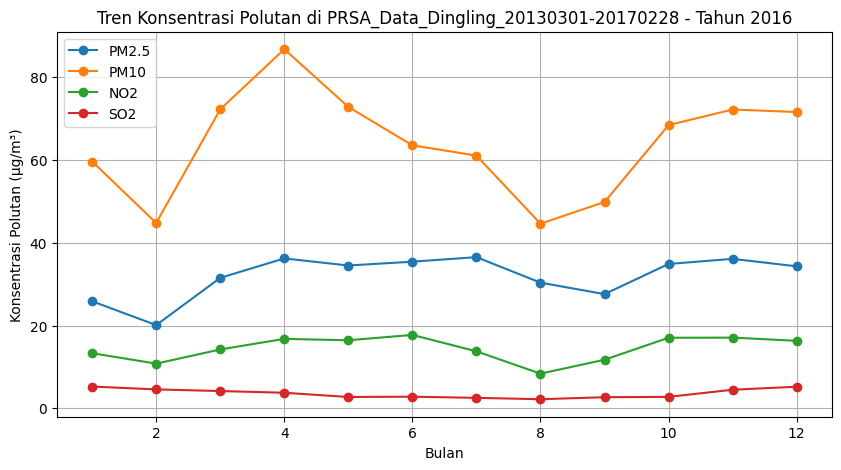

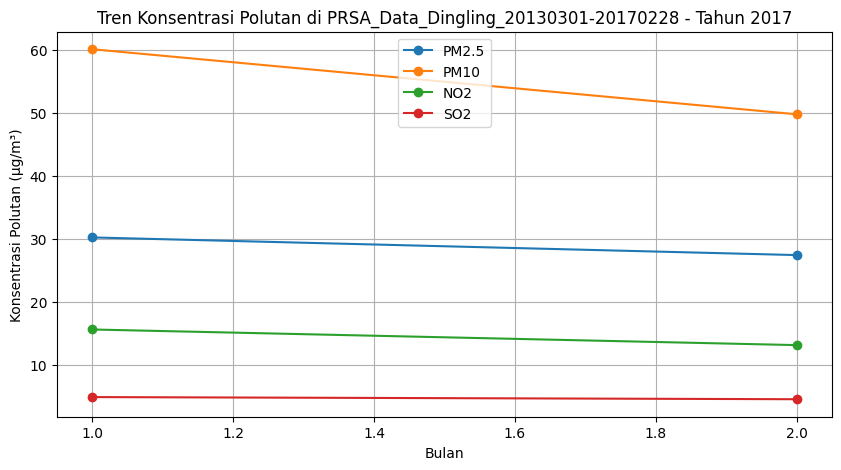

Sedang menganalisa file: PRSA_Data_Dongsi_20130301-20170228


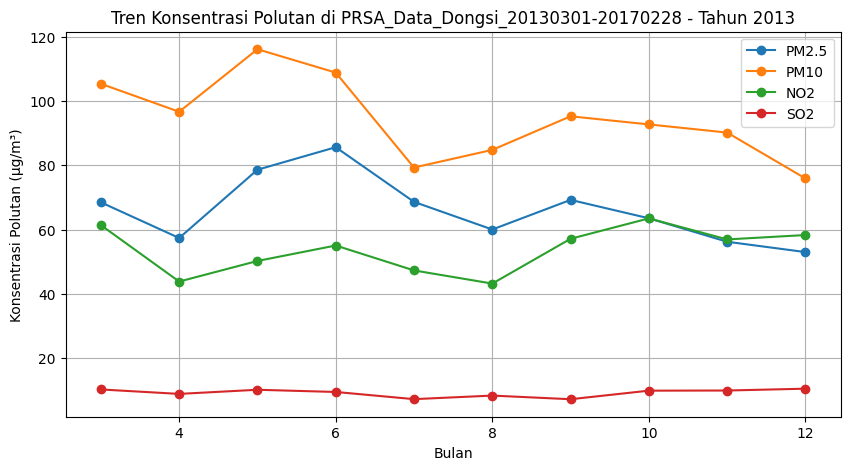

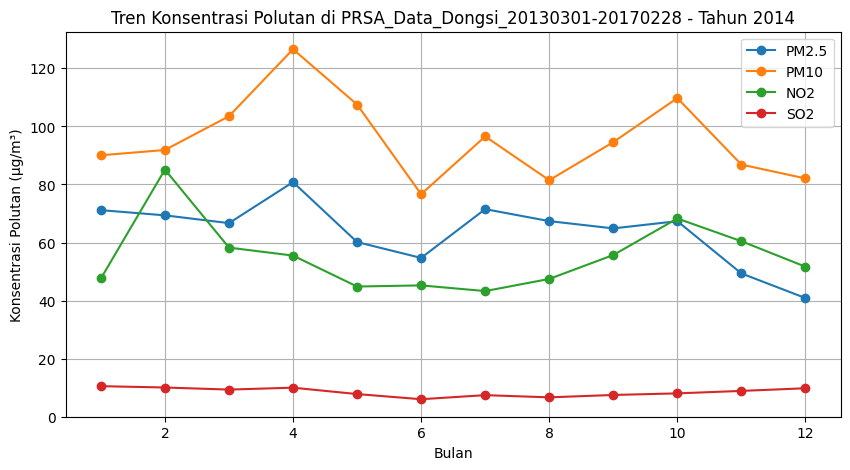

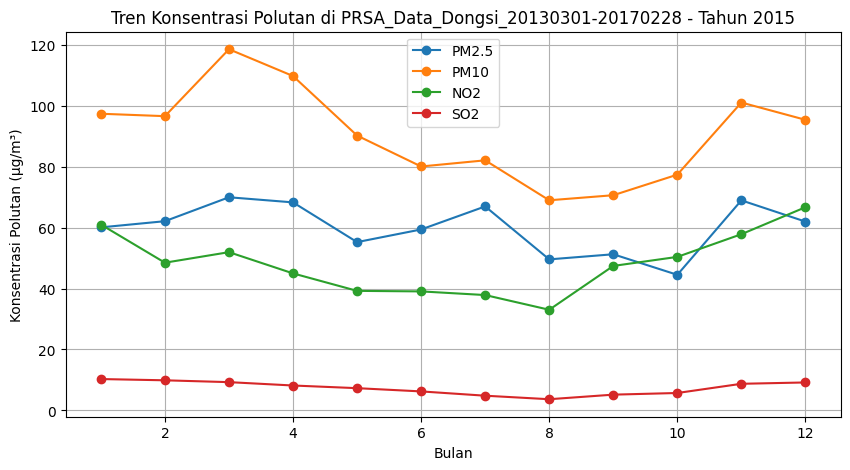

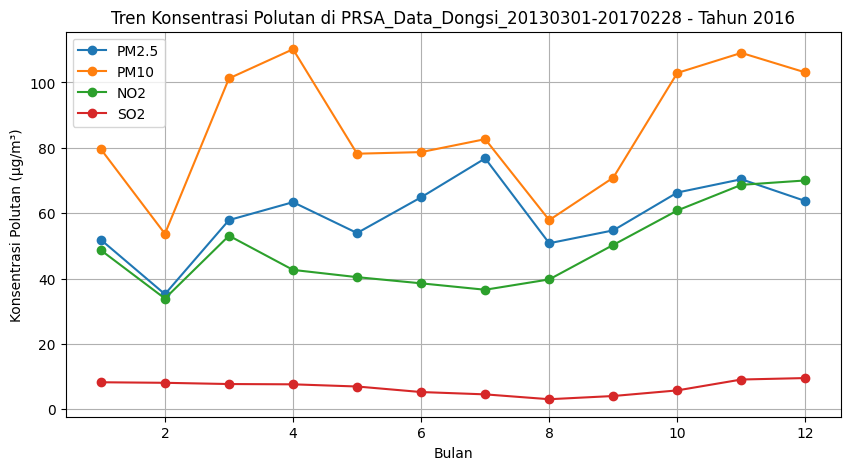

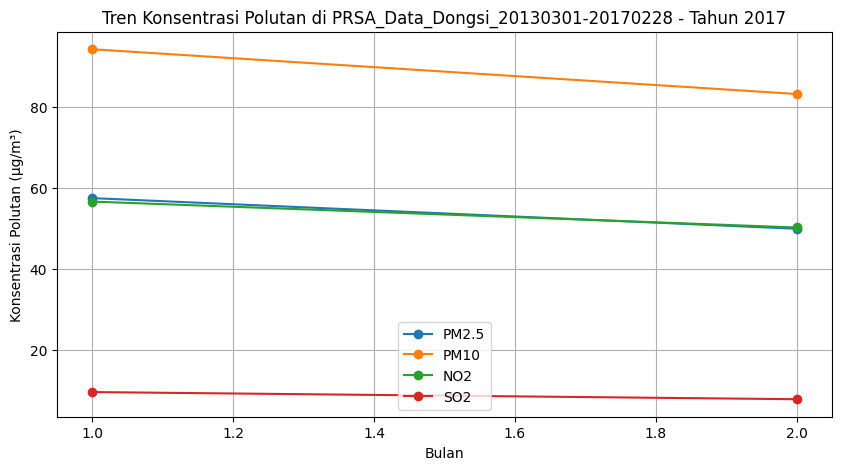

Sedang menganalisa file: PRSA_Data_Guanyuan_20130301-20170228


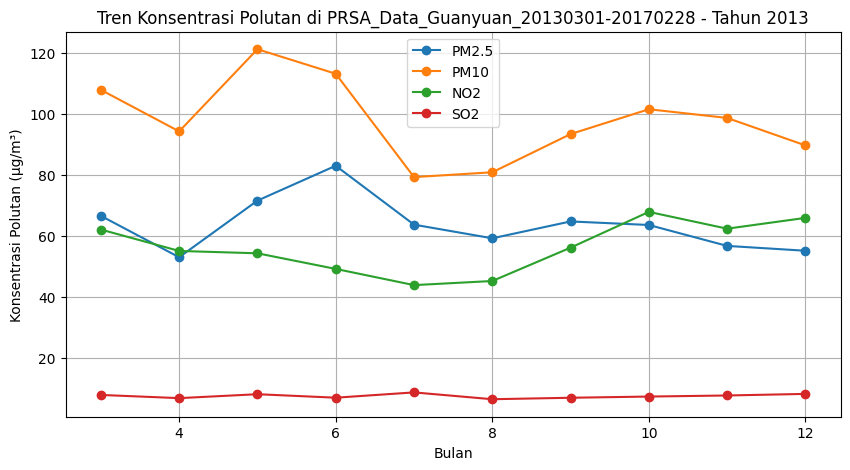

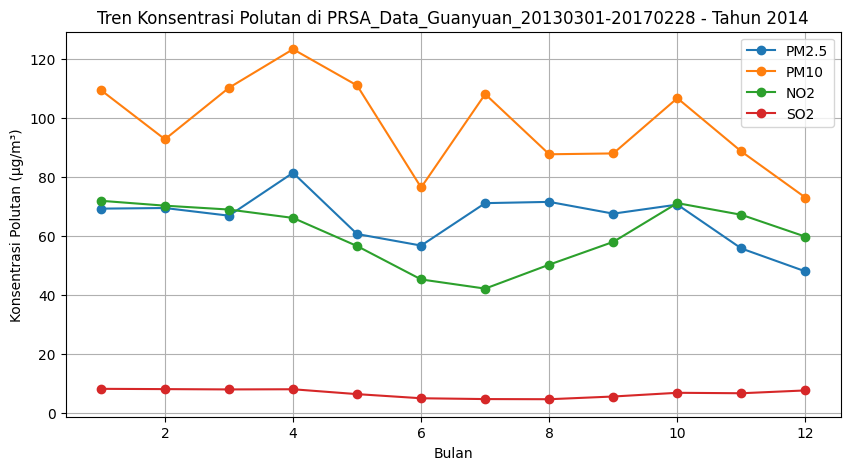

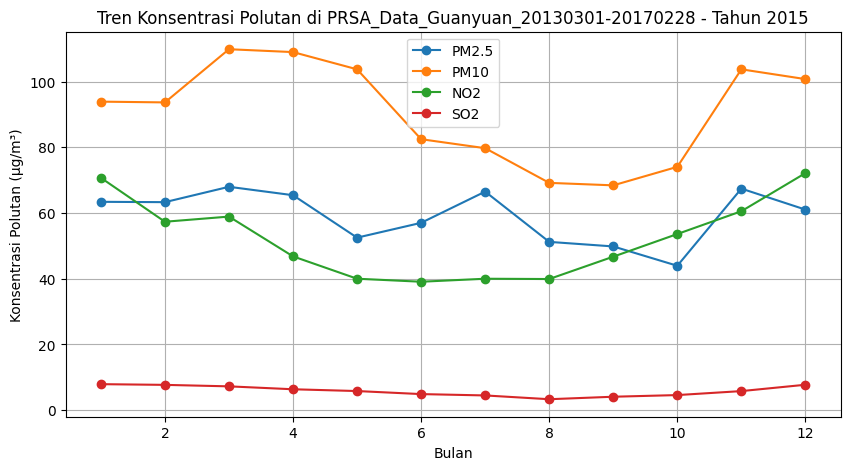

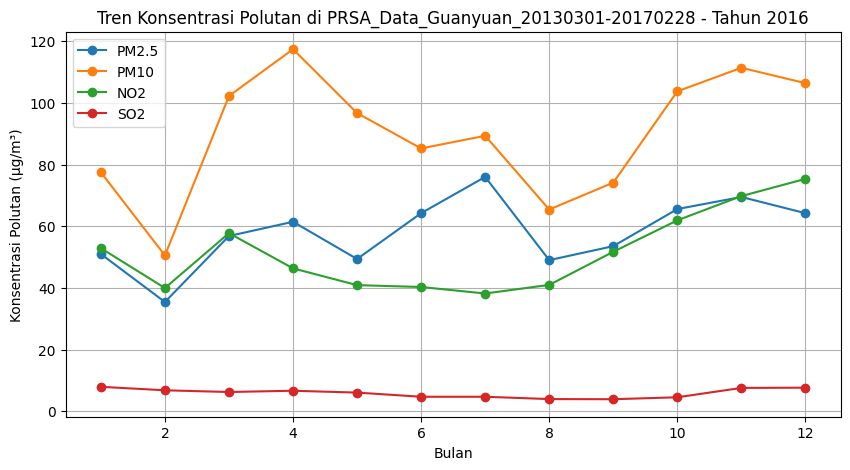

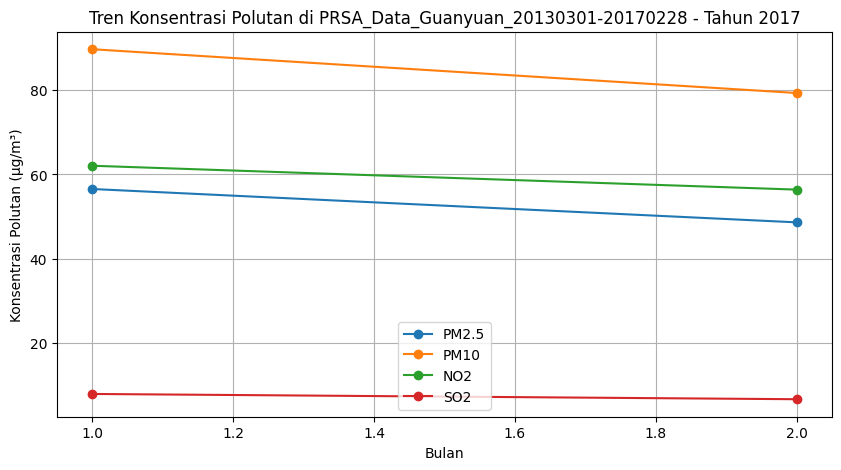

Sedang menganalisa file: PRSA_Data_Gucheng_20130301-20170228


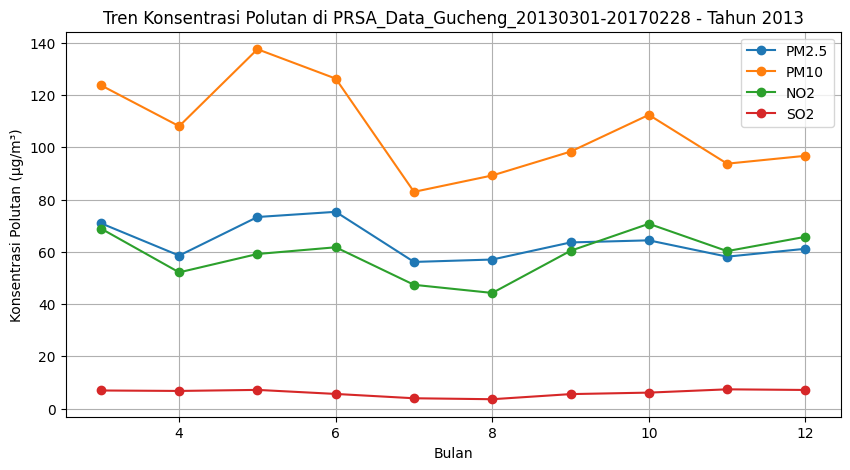

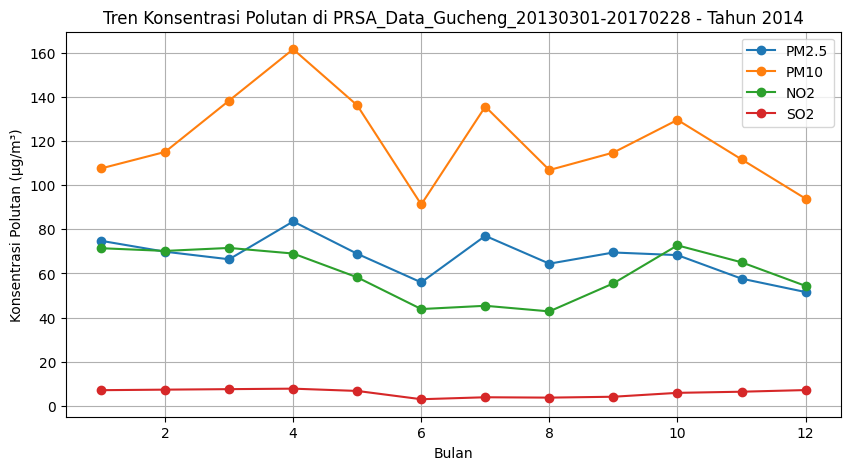

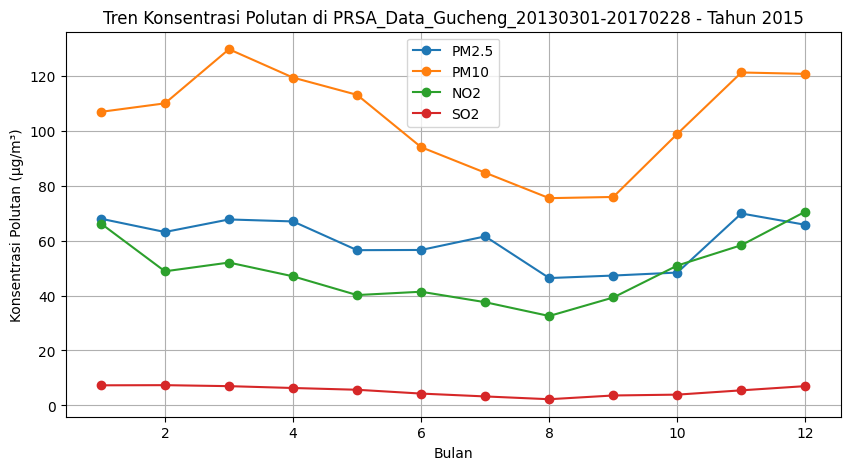

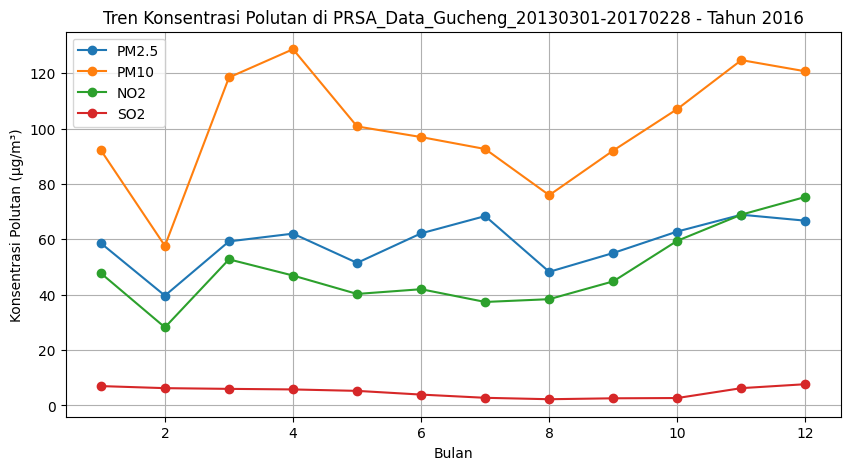

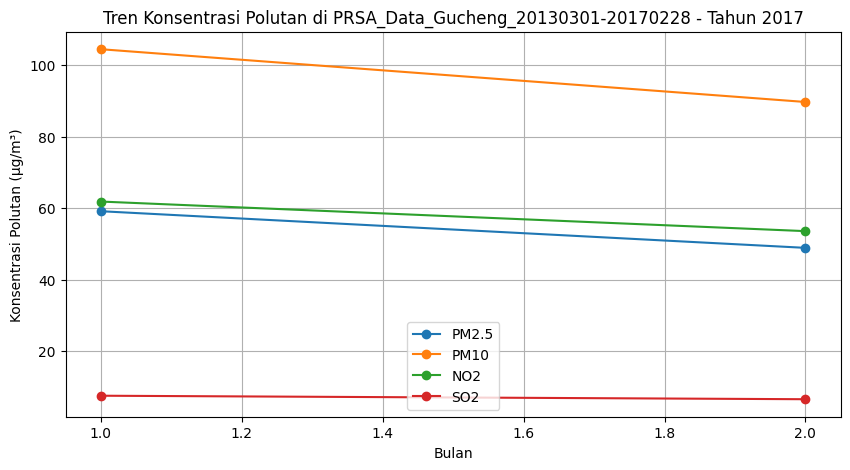

Sedang menganalisa file: PRSA_Data_Huairou_20130301-20170228


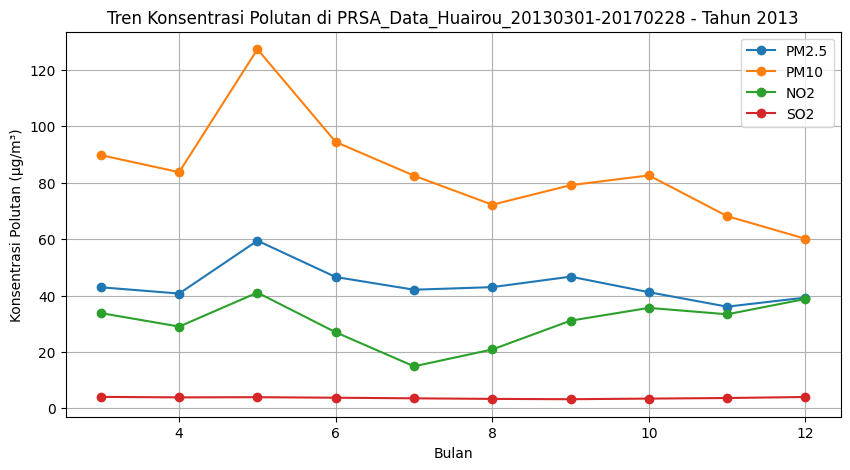

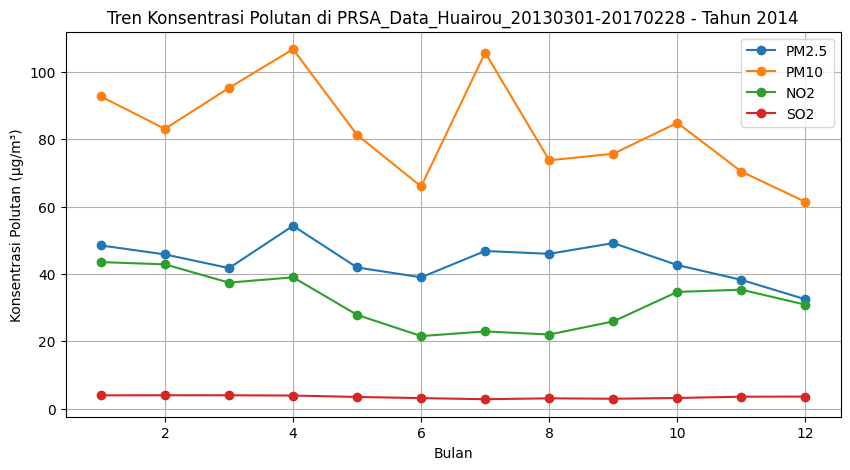

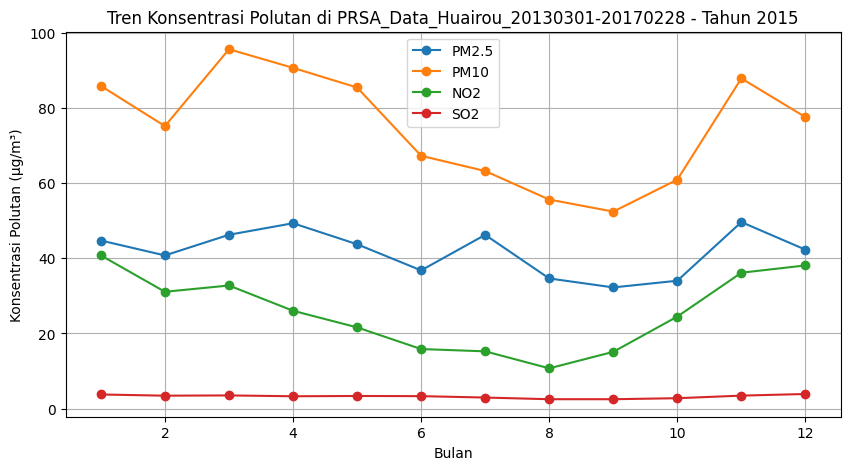

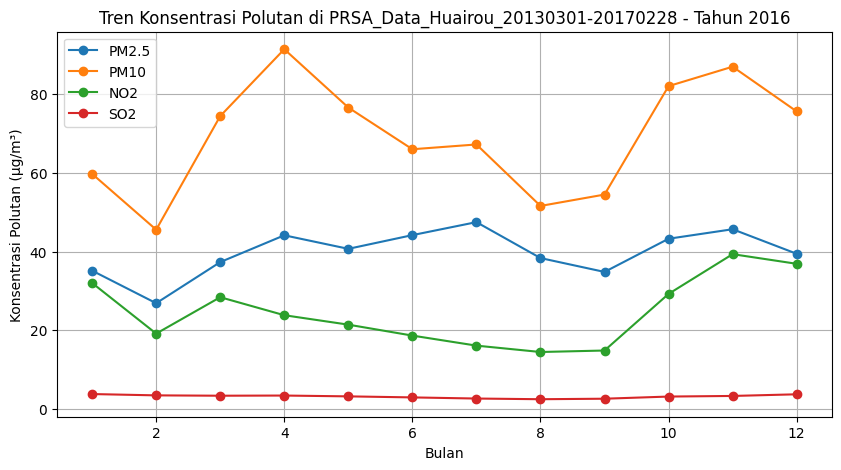

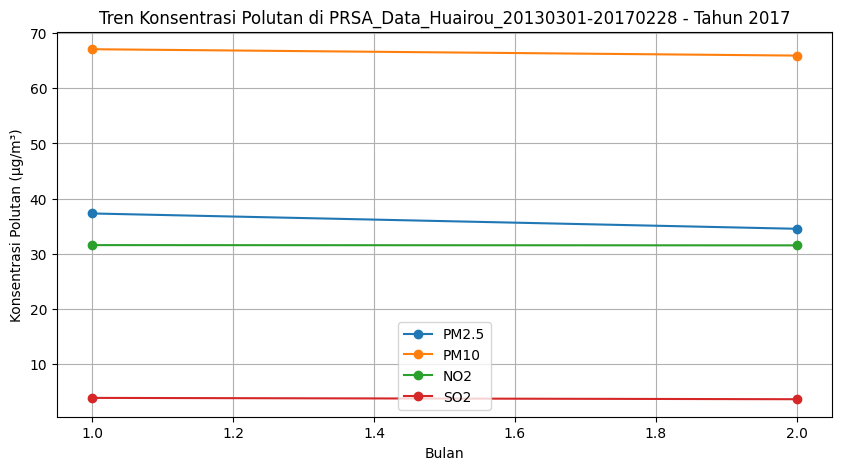

Sedang menganalisa file: PRSA_Data_Nongzhanguan_20130301-20170228


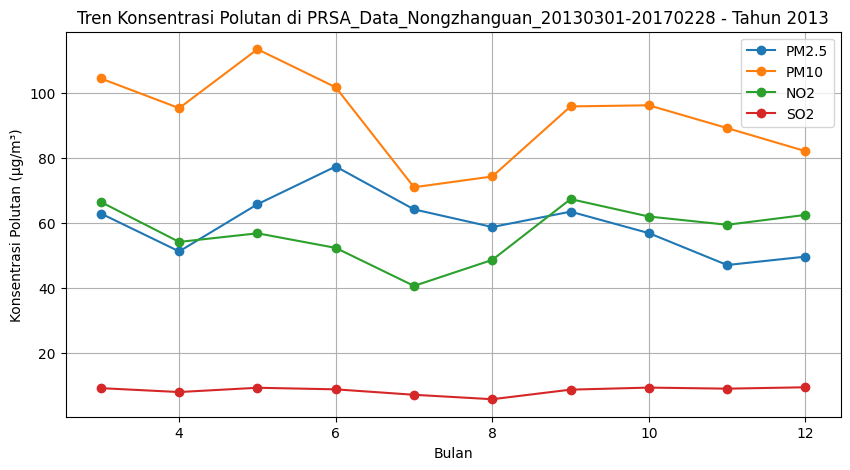

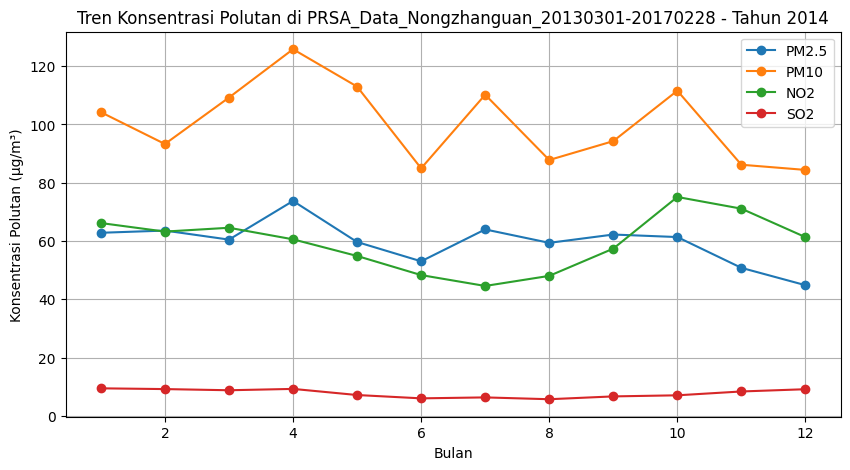

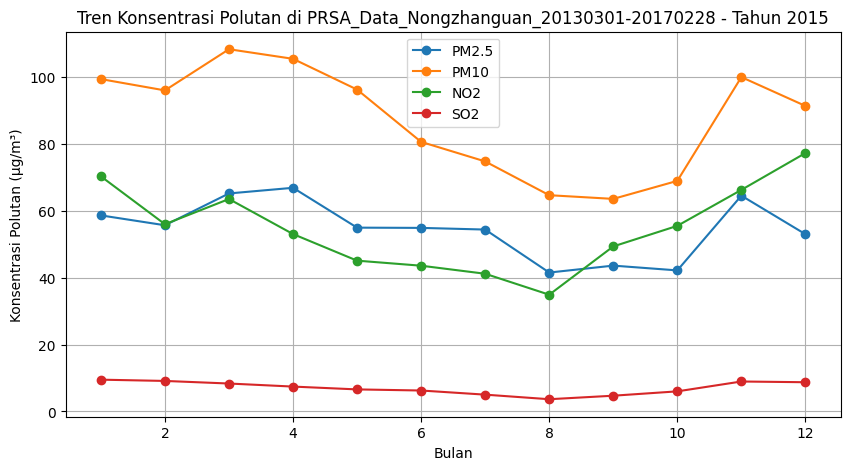

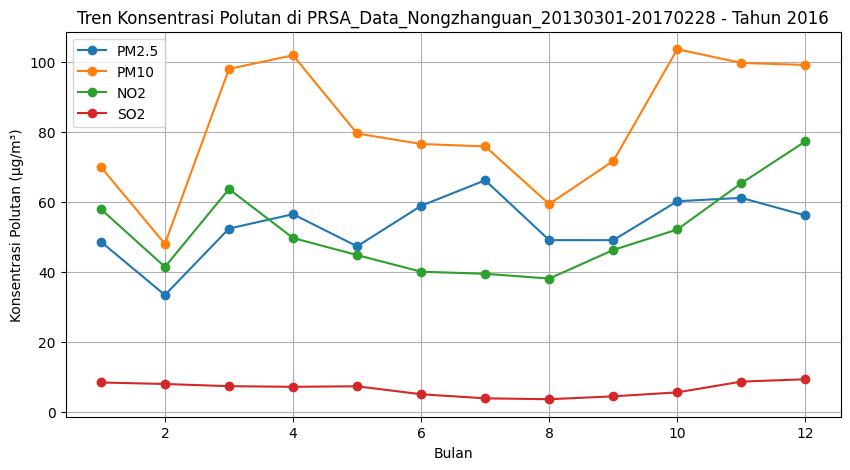

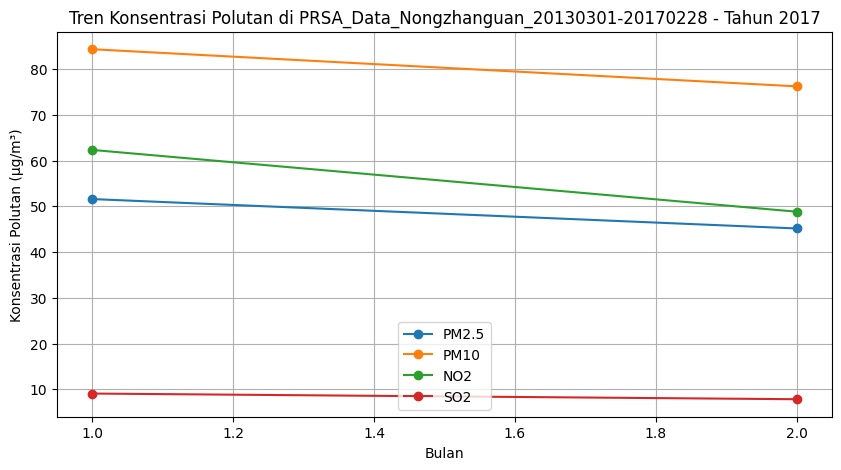

Sedang menganalisa file: PRSA_Data_Shunyi_20130301-20170228


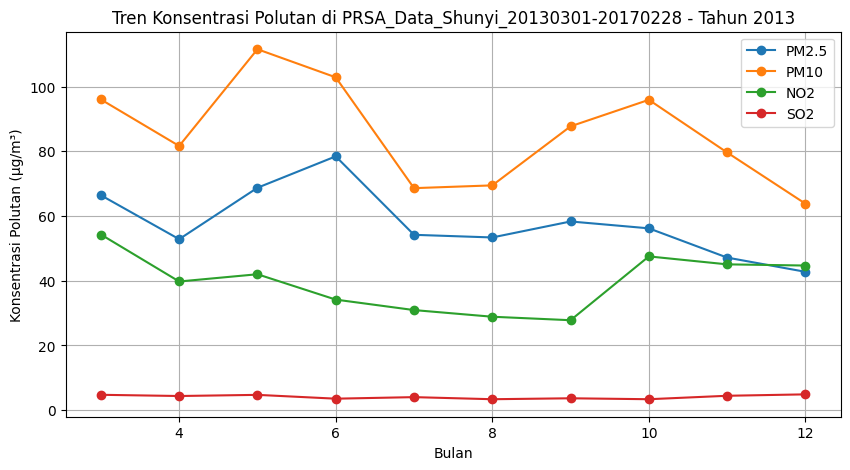

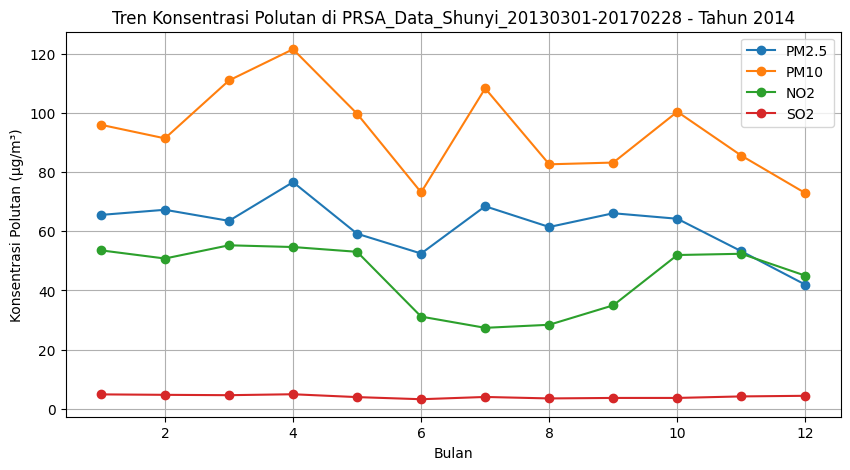

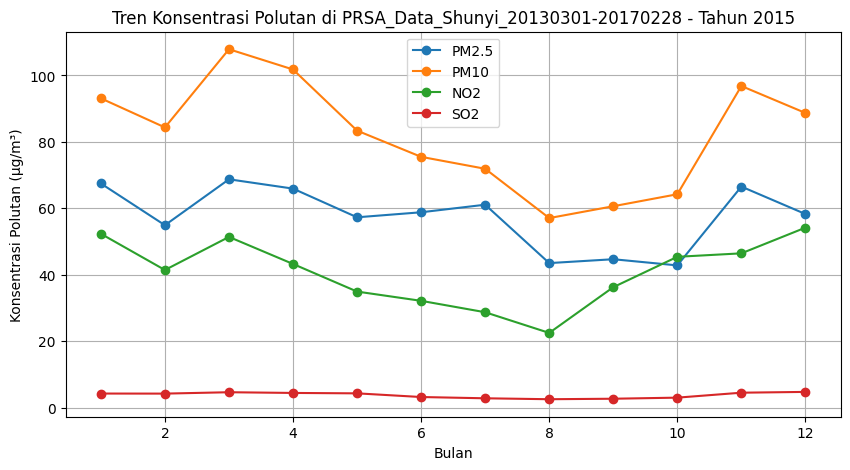

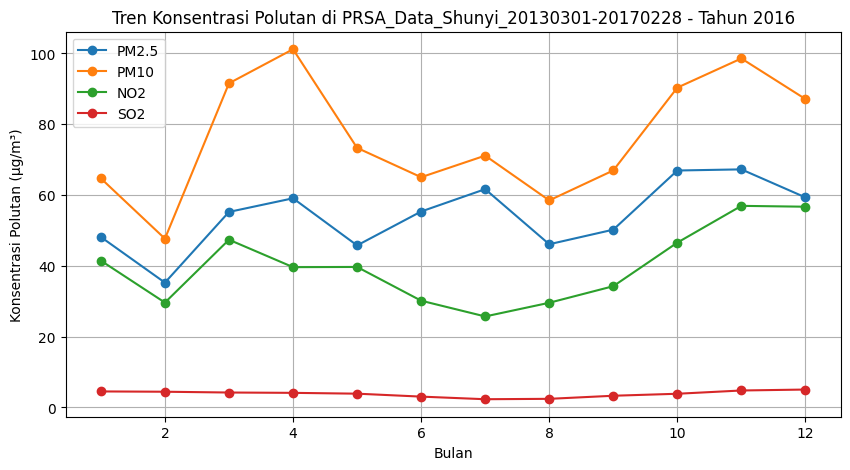

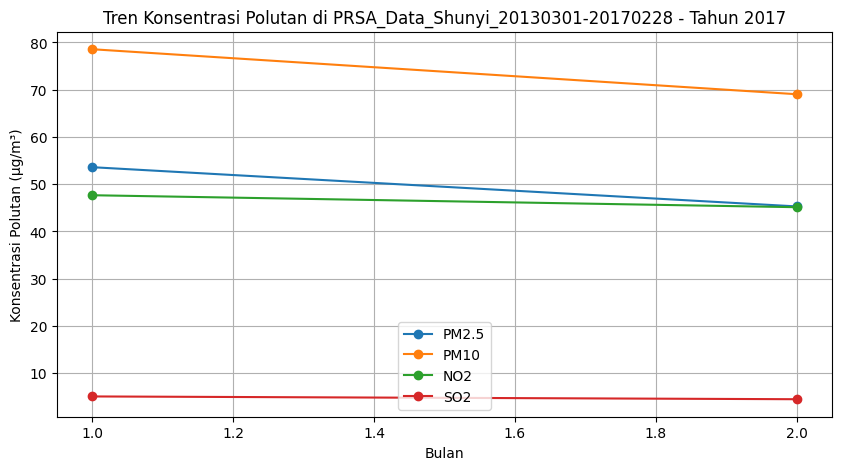

Sedang menganalisa file: PRSA_Data_Tiantan_20130301-20170228


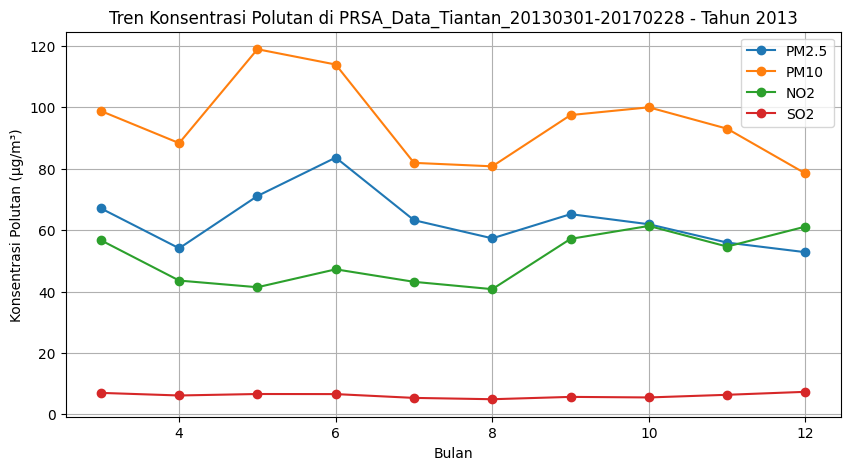

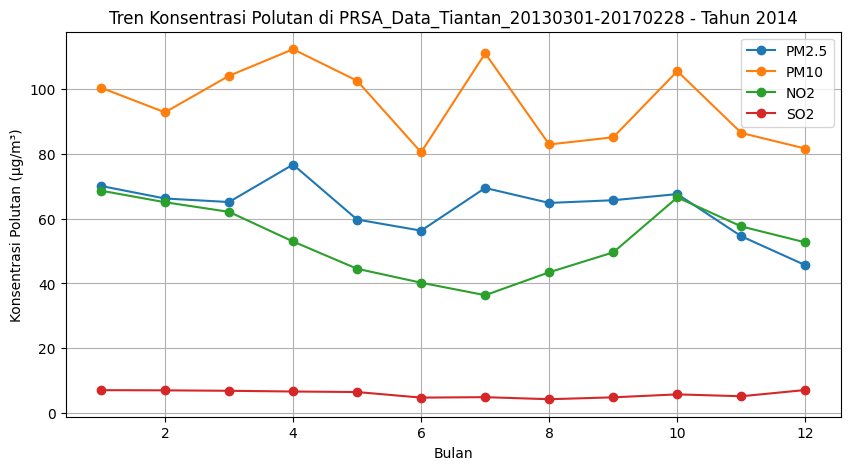

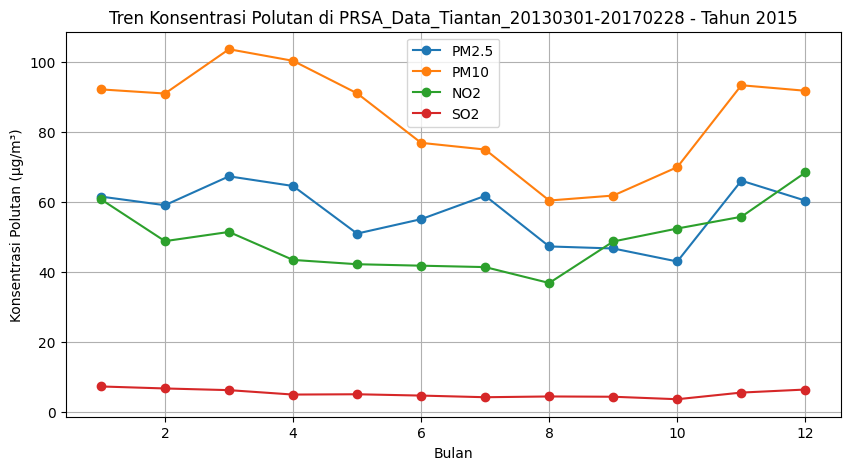

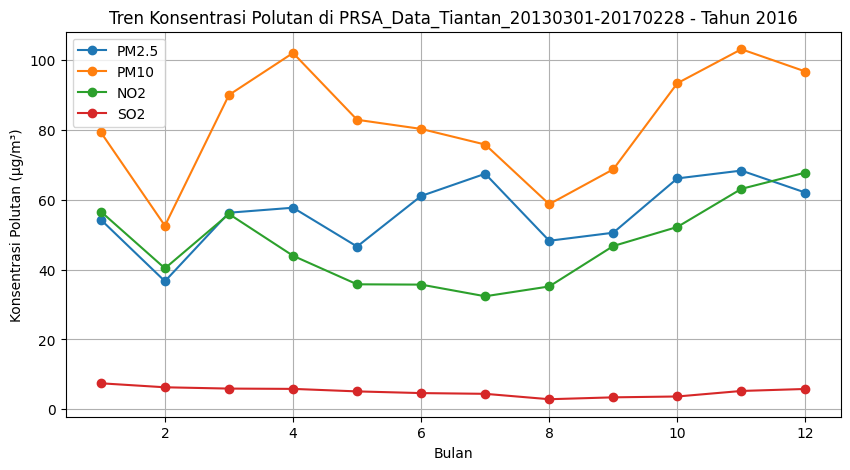

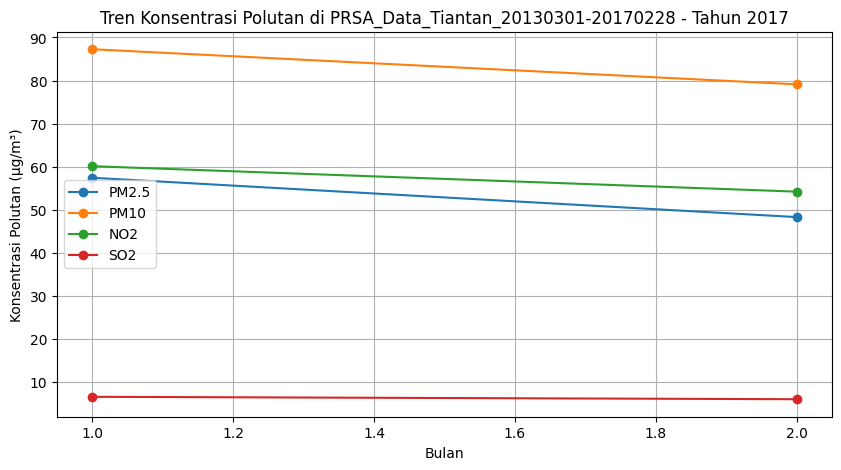

Sedang menganalisa file: PRSA_Data_Wanliu_20130301-20170228


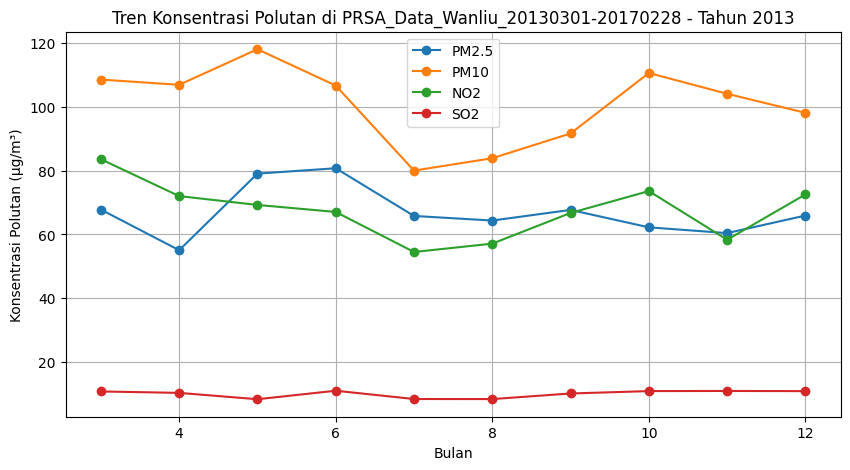

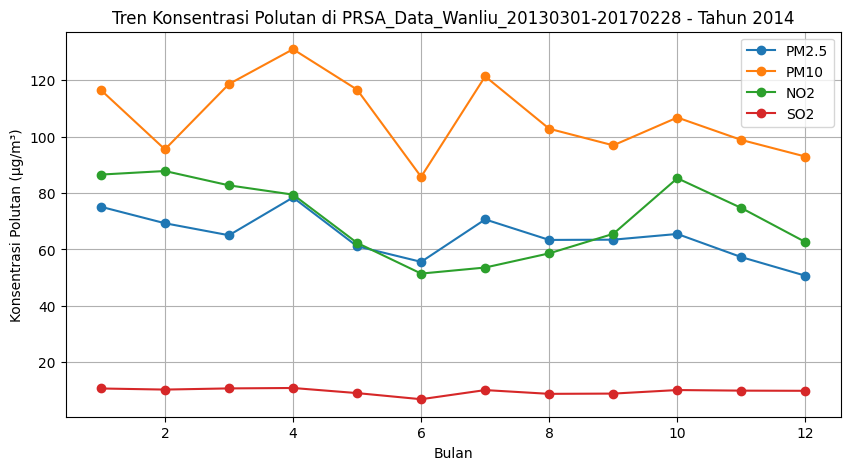

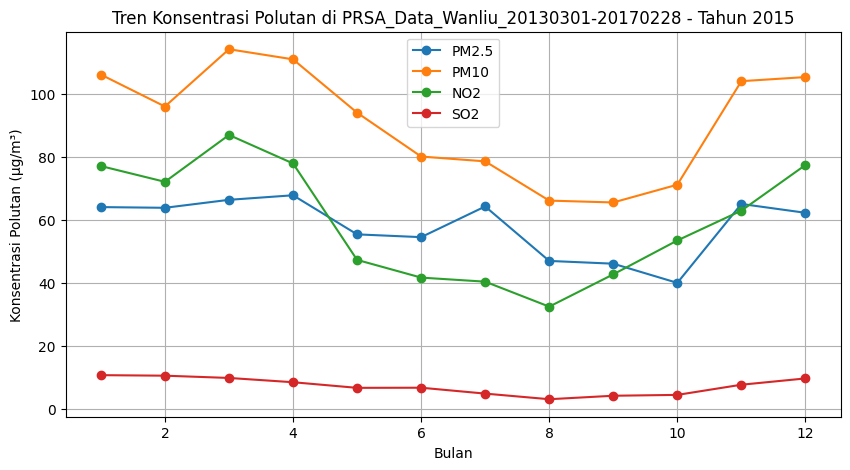

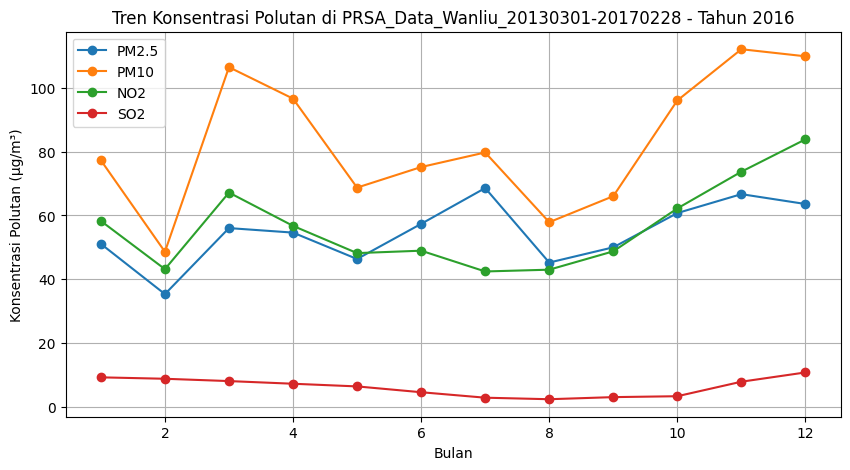

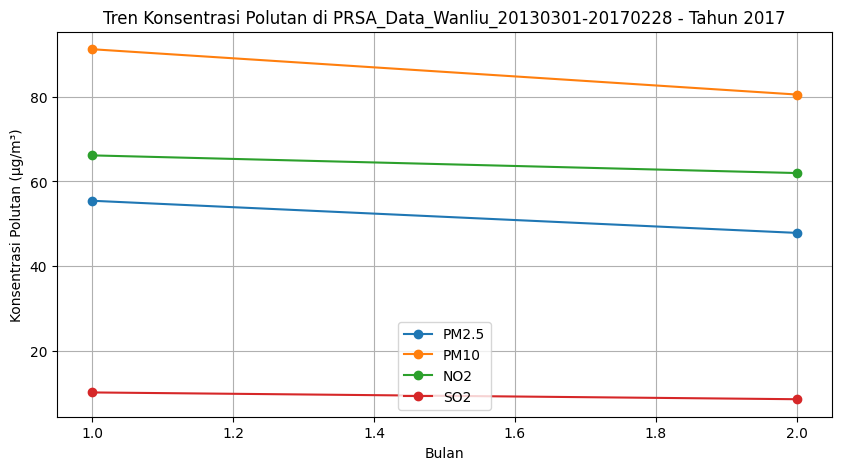

Sedang menganalisa file: PRSA_Data_Wanshouxigong_20130301-20170228


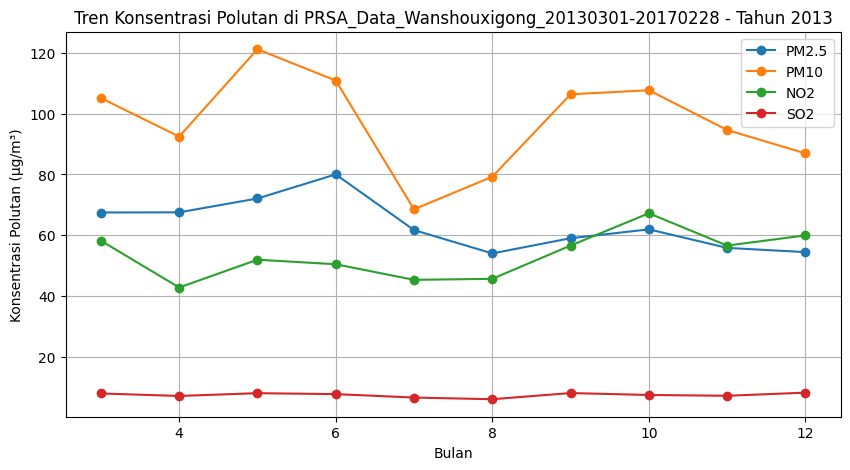

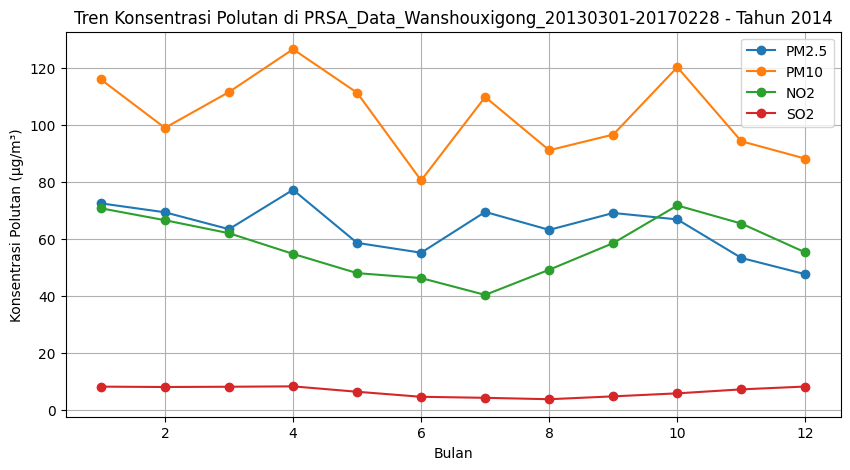

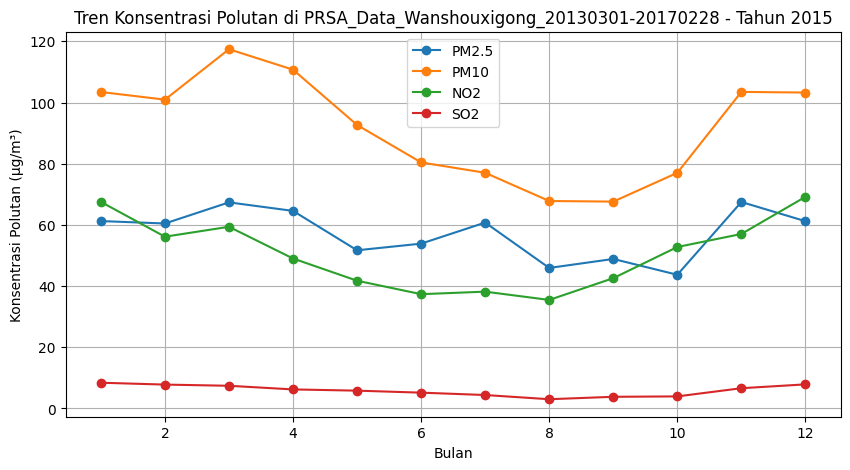

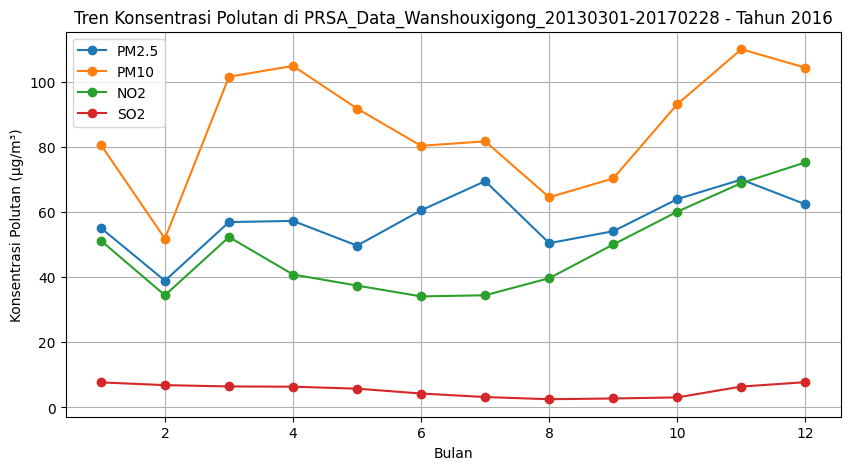

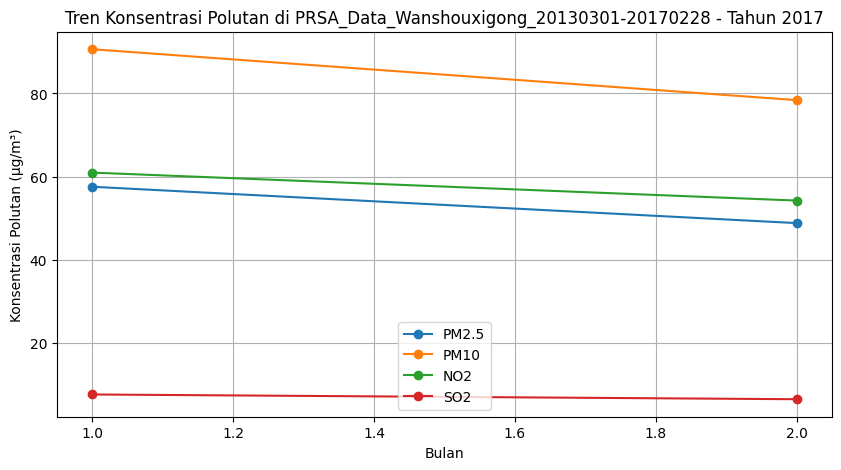


Hasil Analisis Stasiun: PRSA_Data_Aotizhongxin_20130301-20170228

Trend Tahunan:
+------+--------------------+--------------------+--------------------+-------------------+
| year |       PM2.5        |        PM10        |        NO2         |        SO2        |
+------+--------------------+--------------------+--------------------+-------------------+
| 2013 | 62.97324346405229  | 102.16639433551198 | 61.62179176879084  | 8.756112908496732 |
| 2014 | 65.51334474885844  | 101.48228310502283 | 60.48981354642314  | 7.568957123369357 |
| 2015 | 58.687146118721465 | 95.35020547945206  | 57.73756278538813  | 6.962414383561644 |
| 2016 | 55.884085222871256 | 83.23024817850637  | 47.056978597449906 | 6.05134335154827  |
| 2017 | 51.612994350282484 | 81.68185028248588  | 61.22175141242938  | 8.938912429378531 |
+------+--------------------+--------------------+--------------------+-------------------+

Trend Bulanan:
+----+--------+-------+--------------------+--------------------+---------

In [13]:
polutan = ["PM2.5", "PM10", "NO2", "SO2"]

hasil_analisis = {}

file_csv = glob.glob(os.path.join("./data", "PRSA_Data_*.csv"))

for file in file_csv:
    nama_file = os.path.basename(file).replace(".csv", "")
    print("Sedang menganalisa file: " + nama_file)
    
    data = pd.read_csv(file)
    
    if not {"year", "month"}.issubset(data.columns):
        print("Tidak ada kolom 'year' atau 'month' di file " + nama_file + ". Lewati file ini!")
        continue

    # Kelompokkan data per tahun dan bulan, lalu hitung rata-rata tiap polutan
    data_bulanan = data.groupby(["year", "month"])[polutan].mean().reset_index()

    # Hitung rata-rata tahunan tiap polutan
    data_tahunan = data.groupby("year")[polutan].mean()

    # Cari periode terbaik dan terburuk berdasarkan nilai rata-rata PM2.5
    rata_pm25 = data.groupby(["year", "month"])["PM2.5"].mean()
    periode_terbaik = rata_pm25.idxmin()   # (tahun, bulan) dengan PM2.5 terendah
    periode_terburuk = rata_pm25.idxmax()   # (tahun, bulan) dengan PM2.5 tertinggi

    # Simpan semua hasil analisis ke dalam dictionary
    hasil_analisis[nama_file] = {
        "data_tahunan": data_tahunan,
        "data_bulanan": data_bulanan,
        "periode_terbaik": periode_terbaik,
        "periode_terburuk": periode_terburuk,
    }

    # Tampilkan grafik tren bulanan untuk setiap tahun
    tahun_yang_ada = data_bulanan["year"].unique()
    for tahun in tahun_yang_ada:
        data_per_tahun = data_bulanan[data_bulanan["year"] == tahun]
        plt.figure(figsize=(10, 5))
        # Plot tiap polutan
        for pol in polutan:
            plt.plot(data_per_tahun["month"], data_per_tahun[pol], marker="o", label=pol)
        plt.title("Tren Konsentrasi Polutan di " + nama_file + " - Tahun " + str(tahun))
        plt.xlabel("Bulan")
        plt.ylabel("Konsentrasi Polutan (µg/m³)")
        plt.legend()
        plt.grid(True)
        plt.show()

# Tampilkan hasil analisis per stasiun dalam bentuk tabel
for stasiun in hasil_analisis:
    hasil = hasil_analisis[stasiun]
    print("\n=====================================")
    print("Hasil Analisis Stasiun: " + stasiun)
    print("=====================================")
    
    print("\nTrend Tahunan:")
    print(tabulate(hasil["data_tahunan"], headers="keys", tablefmt="pretty"))
    
    print("\nTrend Bulanan:")
    print(tabulate(hasil["data_bulanan"], headers="keys", tablefmt="pretty"))
    
    # Tampilkan periode dengan kualitas udara terbaik dan terburuk
    tahun_baik, bulan_baik = hasil["periode_terbaik"]
    tahun_buruk, bulan_buruk = hasil["periode_terburuk"]
    print("\nPeriode dengan kualitas udara terbaik (PM2.5 terendah): Tahun " + str(tahun_baik) + ", Bulan " + str(bulan_baik))
    print("Periode dengan kualitas udara terburuk (PM2.5 tertinggi): Tahun " + str(tahun_buruk) + ", Bulan " + str(bulan_buruk))

# Analisis tambahan per stasiun
print("\nAnalisis Tambahan:")
for stasiun in hasil_analisis:
    hasil = hasil_analisis[stasiun]
    print("\nStasiun: " + stasiun)
    
    # Cari tahu tahun dengan rata-rata PM2.5 tertinggi
    tahun_pm25_tertinggi = hasil["data_tahunan"]["PM2.5"].idxmax()
    nilai_pm25_tertinggi = hasil["data_tahunan"]["PM2.5"].max()
    print("Tahun dengan rata-rata PM2.5 tertinggi: " + str(tahun_pm25_tertinggi) + " (" + str(round(nilai_pm25_tertinggi, 2)) + " µg/m³)")
    
    # Cari tahu bulan dengan rata-rata NO2 terendah
    bulan_no2_terendah = hasil["data_bulanan"]["NO2"].idxmin()
    nilai_no2_terendah = hasil["data_bulanan"]["NO2"].min()
    print("Bulan dengan rata-rata NO2 terendah: " + str(bulan_no2_terendah) + " (" + str(round(nilai_no2_terendah, 2)) + " µg/m³)")


### Pertanyaan 2:

2. Kapan periode dengan kualitas udara terburuk dan terbaik di setiap lokasi?

Periode kualitas udara terbaik di PRSA_Data_Aotizhongxin_20130301-20170228: (2016, 2), PM2.5 rata-rata: 34.95
Periode kualitas udara terburuk di PRSA_Data_Aotizhongxin_20130301-20170228: (2014, 4), PM2.5 rata-rata: 89.92
Periode kualitas udara terbaik di PRSA_Data_Changping_20130301-20170228: (2014, 12), PM2.5 rata-rata: 42.97
Periode kualitas udara terburuk di PRSA_Data_Changping_20130301-20170228: (2014, 4), PM2.5 rata-rata: 80.08
Periode kualitas udara terbaik di PRSA_Data_Dingling_20130301-20170228: (2016, 2), PM2.5 rata-rata: 20.13
Periode kualitas udara terburuk di PRSA_Data_Dingling_20130301-20170228: (2015, 11), PM2.5 rata-rata: 43.08
Periode kualitas udara terbaik di PRSA_Data_Dongsi_20130301-20170228: (2016, 2), PM2.5 rata-rata: 35.23
Periode kualitas udara terburuk di PRSA_Data_Dongsi_20130301-20170228: (2013, 6), PM2.5 rata-rata: 85.62
Periode kualitas udara terbaik di PRSA_Data_Guanyuan_20130301-20170228: (2016, 2), PM2.5 rata-rata: 35.42
Periode kualitas udara terburuk di

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20108\3116415109.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(best_pm25.keys()), y=list(best_pm25.values()), palette="Blues_r")


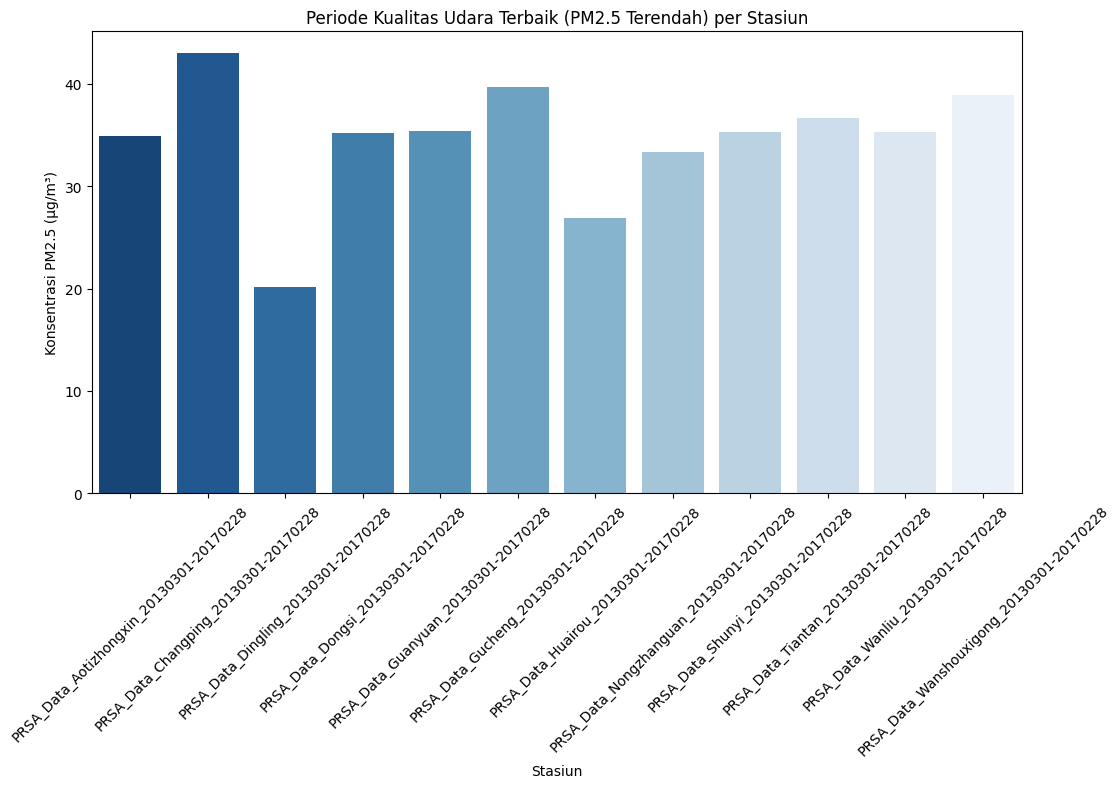

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20108\3116415109.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(worst_pm25.keys()), y=list(worst_pm25.values()), palette="Reds_r")


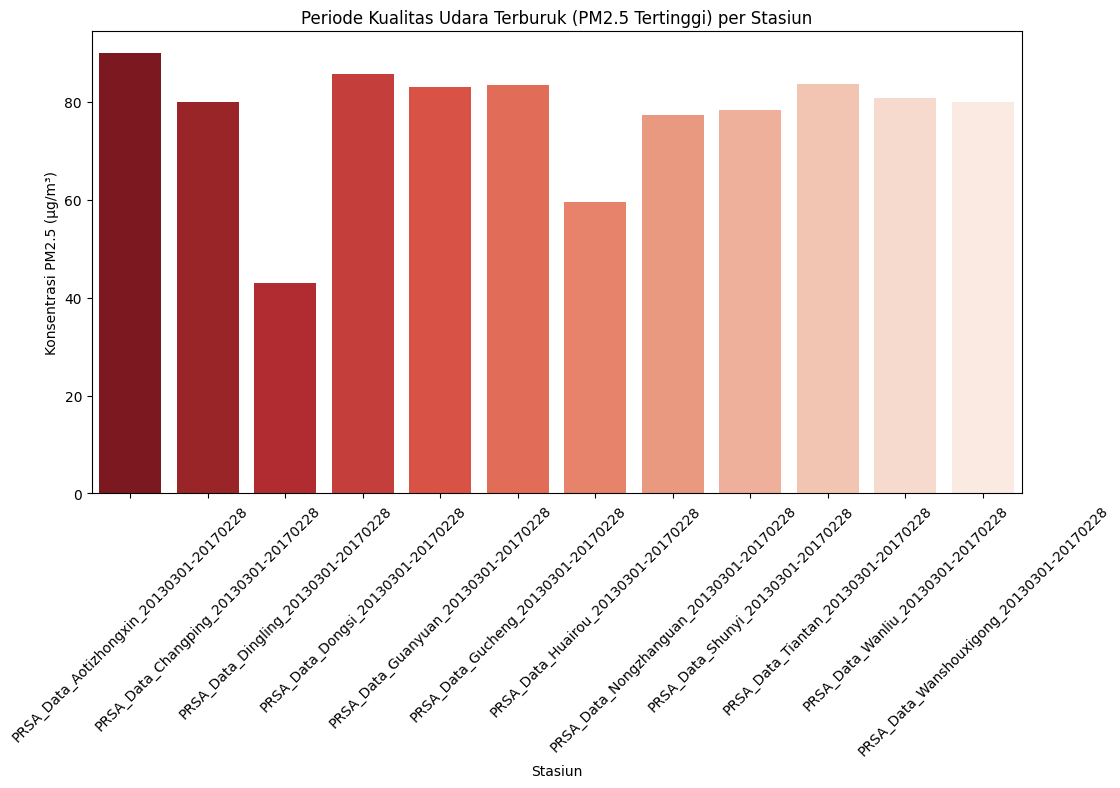

In [14]:
best_pm25 = {}  
worst_pm25 = {}

for file in files:
    nama_file = os.path.basename(file).replace(".csv", "")
    df = pd.read_csv(file)
    
    # Cek apakah kolom yang dibutuhkan ada
    if not set(["year", "month", "PM2.5"]).issubset(df.columns):
        print(f"Lewati {nama_file}, kolom tidak lengkap.")
        continue
    
    # Cek periode dengan kualitas udara terbaik & terburuk
    try:
        best_air_quality = df.groupby(["year", "month"])['PM2.5'].mean().idxmin()
        worst_air_quality = df.groupby(["year", "month"])['PM2.5'].mean().idxmax()
    except Exception as e:
        print(f"Gagal memproses {nama_file}: {e}")
        continue
    
    # Ambil nilai rata-rata PM2.5 untuk periode terbaik & terburuk
    best_pm25[nama_file] = df[(df["year"] == best_air_quality[0]) & (df["month"] == best_air_quality[1])]['PM2.5'].mean()
    worst_pm25[nama_file] = df[(df["year"] == worst_air_quality[0]) & (df["month"] == worst_air_quality[1])]['PM2.5'].mean()
    
    print(f"Periode kualitas udara terbaik di {nama_file}: {best_air_quality}, PM2.5 rata-rata: {best_pm25[nama_file]:.2f}")
    print(f"Periode kualitas udara terburuk di {nama_file}: {worst_air_quality}, PM2.5 rata-rata: {worst_pm25[nama_file]:.2f}")

# Plot hasil analisis
plt.figure(figsize=(12, 6))
sns.barplot(x=list(best_pm25.keys()), y=list(best_pm25.values()), palette="Blues_r")
plt.xticks(rotation=45)
plt.title("Periode Kualitas Udara Terbaik (PM2.5 Terendah) per Stasiun")
plt.xlabel("Stasiun")
plt.ylabel("Konsentrasi PM2.5 (µg/m³)")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=list(worst_pm25.keys()), y=list(worst_pm25.values()), palette="Reds_r")
plt.xticks(rotation=45)
plt.title("Periode Kualitas Udara Terburuk (PM2.5 Tertinggi) per Stasiun")
plt.xlabel("Stasiun")
plt.ylabel("Konsentrasi PM2.5 (µg/m³)")
plt.show()


**Insight:**
## 1. Tren tahunan konsentrasi polutan utama di setiap lokasi dari tahun ke tahun
- **Tren tahunan PM2.5**:
  - Kualitas udara membaik secara keseluruhan pada tahun **2016**, dengan periode terbaik di bulan Februari.
  - Tahun **2013 dan 2014** menunjukkan tingkat PM2.5 tertinggi di banyak lokasi, terutama pada bulan Juni 2013.
- **Tren NO₂**:
  - Konsentrasi NO₂ lebih rendah di beberapa bulan tertentu, dengan nilai terendah bervariasi di setiap lokasi.
  - Tidak ada pola spesifik yang menunjukkan tren penurunan atau peningkatan NO₂ yang konsisten.

## 2. Periode dengan kualitas udara terburuk dan terbaik di setiap lokasi
- **Periode dengan kualitas udara terbaik secara umum terjadi pada Februari 2016**, dengan beberapa lokasi menunjukkan konsentrasi PM2.5 terendah.
- **Periode dengan kualitas udara terburuk bervariasi**, tetapi sering terjadi pada April 2014 atau Juni 2013 di banyak lokasi.
- **Lokasi dengan PM2.5 tertinggi selama periode buruk**:
  - PRSA_Data_Aotizhongxin (April 2014, 89.92 µg/m³)
  - PRSA_Data_Dongsi (Juni 2013, 85.62 µg/m³)
  - PRSA_Data_Tiantan (Juni 2013, 83.63 µg/m³)

  ### Detail Per Lokasi

  #### PRSA_Data_Aotizhongxin
  - **Terbaik**: Februari 2016, PM2.5 rata-rata: **34.95 µg/m³**
  - **Terburuk**: April 2014, PM2.5 rata-rata: **89.92 µg/m³**

  #### PRSA_Data_Changping
  - **Terbaik**: Desember 2014, PM2.5 rata-rata: **42.97 µg/m³**
  - **Terburuk**: April 2014, PM2.5 rata-rata: **80.08 µg/m³**

  #### PRSA_Data_Dingling
  - **Terbaik**: Februari 2016, PM2.5 rata-rata: **20.13 µg/m³**
  - **Terburuk**: November 2015, PM2.5 rata-rata: **43.08 µg/m³**

  #### PRSA_Data_Dongsi
  - **Terbaik**: Februari 2016, PM2.5 rata-rata: **35.23 µg/m³**
  - **Terburuk**: Juni 2013, PM2.5 rata-rata: **85.62 µg/m³**

  #### PRSA_Data_Guanyuan
  - **Terbaik**: Februari 2016, PM2.5 rata-rata: **35.42 µg/m³**
  - **Terburuk**: Juni 2013, PM2.5 rata-rata: **83.05 µg/m³**

  #### PRSA_Data_Gucheng
  - **Terbaik**: Februari 2016, PM2.5 rata-rata: **39.68 µg/m³**
  - **Terburuk**: April 2014, PM2.5 rata-rata: **83.57 µg/m³**

  #### PRSA_Data_Huairou
  - **Terbaik**: Februari 2016, PM2.5 rata-rata: **27.98 µg/m³**
  - **Terburuk**: Mei 2013, PM2.5 rata-rata: **60.96 µg/m³**

  #### PRSA_Data_Nongzhanguan
  - **Terbaik**: Februari 2016, PM2.5 rata-rata: **33.35 µg/m³**
  - **Terburuk**: Juni 2013, PM2.5 rata-rata: **77.36 µg/m³**

  #### PRSA_Data_Shunyi
  - **Terbaik**: Februari 2016, PM2.5 rata-rata: **35.26 µg/m³**
  - **Terburuk**: Juni 2013, PM2.5 rata-rata: **78.44 µg/m³**

  #### PRSA_Data_Tiantan
  - **Terbaik**: Februari 2016, PM2.5 rata-rata: **36.68 µg/m³**
  - **Terburuk**: Juni 2013, PM2.5 rata-rata: **83.63 µg/m³**

  #### PRSA_Data_Wanliu
  - **Terbaik**: Februari 2016, PM2.5 rata-rata: **35.30 µg/m³**
  - **Terburuk**: Juni 2013, PM2.5 rata-rata: **80.79 µg/m³**

  #### PRSA_Data_Wanshouxigong
  - **Terbaik**: Februari 2016, PM2.5 rata-rata: **38.95 µg/m³**
  - **Terburuk**: Juni 2013, PM2.5 rata-rata: **80.01 µg/m³**

## Analisis Lanjutan (Manual Grouping)

In [22]:
file_csv = glob.glob(os.path.join("./data", "PRSA_Data_*.csv"))

for file in file_csv:
    nama_file = os.path.basename(file).replace(".csv", "")
    print("Sedang menganalisa file: " + nama_file)

    # Baca CSV dengan path yang benar
    df = pd.read_csv(file)

    # Pastikan kolom 'PM2.5' memiliki nilai numerik dan bersih dari NaN
    df["PM2.5"] = pd.to_numeric(df["PM2.5"], errors="coerce")
    df.dropna(subset=["PM2.5"], inplace=True)

    # Hitung rata-rata PM2.5 untuk setiap stasiun
    stations_avg = df.groupby("station", as_index=False)["PM2.5"].mean()

    # Fungsi untuk mengelompokkan berdasarkan kategori
    def categorize_pm25(value):
        if value <= 50:
            return "Baik"
        elif value <= 100:
            return "Sedang"
        elif value <= 150:
            return "Tidak Sehat"
        elif value <= 200:
            return "Sangat Tidak Sehat"
        else:
            return "Berbahaya"

    # Tambahkan kategori ke dataset
    stations_avg["Kategori"] = stations_avg["PM2.5"].apply(categorize_pm25)

    # Tampilkan hasil
    print(stations_avg)

Sedang menganalisa file: PRSA_Data_Aotizhongxin_20130301-20170228
        station     PM2.5 Kategori
0  Aotizhongxin  60.30235   Sedang
Sedang menganalisa file: PRSA_Data_Changping_20130301-20170228
     station      PM2.5 Kategori
0  Changping  56.371993   Sedang
Sedang menganalisa file: PRSA_Data_Dingling_20130301-20170228
    station      PM2.5 Kategori
0  Dingling  32.509725     Baik
Sedang menganalisa file: PRSA_Data_Dongsi_20130301-20170228
  station      PM2.5 Kategori
0  Dongsi  61.695062   Sedang
Sedang menganalisa file: PRSA_Data_Guanyuan_20130301-20170228
    station      PM2.5 Kategori
0  Guanyuan  61.214906   Sedang
Sedang menganalisa file: PRSA_Data_Gucheng_20130301-20170228
   station      PM2.5 Kategori
0  Gucheng  62.042145   Sedang
Sedang menganalisa file: PRSA_Data_Huairou_20130301-20170228
   station      PM2.5 Kategori
0  Huairou  41.986308     Baik
Sedang menganalisa file: PRSA_Data_Nongzhanguan_20130301-20170228
        station      PM2.5 Kategori
0  Nongzhanguan

## Conclusion

## **Kesimpulan Analisis Kualitas Udara**

### **Tren Tahunan Konsentrasi Polutan Utama di Setiap Lokasi**
- **PM2.5**:
  - Kualitas udara membaik secara keseluruhan pada tahun **2016**, terutama di bulan Februari.
  - Tahun **2013 dan 2014** memiliki tingkat PM2.5 tertinggi di banyak lokasi, dengan **Juni 2013** sebagai bulan dengan konsentrasi tertinggi.
- **NO₂**:
  - Konsentrasi NO₂ cenderung lebih rendah di beberapa bulan tertentu.
  - Tidak ada tren penurunan atau peningkatan yang signifikan selama periode analisis.

---

### **Periode dengan Kualitas Udara Terbaik dan Terburuk**
- **Periode dengan kualitas udara terbaik secara umum adalah Februari 2016**, dengan beberapa lokasi mencatat PM2.5 terendah.
- **Periode dengan kualitas udara terburuk umumnya terjadi pada April 2014 atau Juni 2013**, dengan beberapa lokasi mencatat konsentrasi tertinggi.
- **Lokasi dengan PM2.5 tertinggi selama periode buruk**:
  - PRSA_Data_Aotizhongxin (April 2014, **89.92 µg/m³**)
  - PRSA_Data_Dongsi (Juni 2013, **85.62 µg/m³**)
  - PRSA_Data_Tiantan (Juni 2013, **83.63 µg/m³**)

---

### **Rata-rata Kategori PM2.5 di Setiap Stasiun**
Berdasarkan hasil perhitungan manual dari data CSV:

| Stasiun | Rata-rata PM2.5 (µg/m³) | Kategori |
|---------|------------------------|-----------|
| Aotizhongxin | 60.3 | Sedang |
| Changping | 56.4 | Sedang |
| Dingling | 32.5 | Baik |
| Dongsi | 61.7 | Sedang |
| Guanyuan | 61.2 | Sedang |
| Gucheng | 62.0 | Sedang |
| Huairou | 42.0 | Baik |
| Nongzhanguan | 56.3 | Sedang |
| Shunyi | 57.5 | Sedang |
| Tiantan | 59.6 | Sedang |
| Wanliu | 60.5 | Sedang |
| Wanshouxigong | 60.1 | Sedang |

---

### **Kesimpulan Utama**
**Sebagian besar lokasi memiliki kualitas udara dalam kategori "Sedang" (PM2.5 antara 50-100 µg/m³)**.
**Dua lokasi, Dingling dan Huairou, memiliki kualitas udara "Baik" dengan PM2.5 di bawah 50 µg/m³**.
**Tidak ada lokasi yang masuk dalam kategori "Tidak Sehat" atau lebih buruk (PM2.5 di atas 100 µg/m³)**.
**Kualitas udara terbaik terjadi pada Februari 2016, sedangkan periode dengan polusi tertinggi bervariasi antar lokasi, tetapi sering terjadi pada 2013-2014**.
